In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.datasets as dset
from data import image_manipulation
from data import dataloader as img_dataloader
from torch.autograd import Variable
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader

torch.cuda.is_available()

True

In [2]:
# random seed for reproducibility
random_seed = 69

np.random.seed(random_seed)

In [3]:
# no of workers for dataloader
no_of_workers = 4

# root of the data
data_root = "data/train/"

# batch size
batch_size = 1

#no of epochs
n_epochs = 10

# learning rate
lr = 0.0002

# betas for adam
beta_1 = 0.5
beta_2 = 0.999

# image size
image_height = 256
image_width = 256

In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [6]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize = True, dropout = 0.0):
        super(UNetDown, self).__init__()
        layers = [
            nn.Conv2d(in_size, out_size, 4, 2, 1, bias = False)
        ]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
            
        layers.append(nn.LeakyReLU(0.2))
        
        if dropout:
            layers.append(nn.Dropout(dropout))
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [8]:
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout = 0.0):
        super(UNetUp, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)
        
    
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

In [9]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        # unet connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

## Model Train

In [18]:
#initialize model classes
generator = GeneratorUNet()
discriminator = Discriminator()


# check if cuda is avialbale
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(cuda)

# initialize weights if the model is not found in the paths
if os.path.exists("saved_models/generator.pth"):
    print("Generator Found")
    generator.load_state_dict(torch.load("saved_models/generator.pth", map_location = device))
else:
    generator.apply(weights_init_normal)
                                         
if os.path.exists("saved_models/discriminator.pth"):
    print("Discriminator Found")
    discriminator.load_state_dict(torch.load("saved_models/discriminator.pth", map_location = device))
else:
    discriminator.apply(weights_init_normal)

# model loss functions
loss_fn_generator = torch.nn.MSELoss() # mean squared loss
loss_fn_disc = torch.nn.L1Loss() #pixel wise loss

# to cuda if cuda is avaiable
generator.to(device)
discriminator.to(device)
loss_fn_disc.to(device)
loss_fn_generator.to(device)
    
# optimizers
optimier_G = torch.optim.Adam(generator.parameters(), betas=(beta_1, beta_2), lr=lr)
optimier_D = torch.optim.Adam(discriminator.parameters(), betas=(beta_1, beta_2), lr=lr)

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, image_height // 2 ** 4, image_width // 2 ** 4)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

True


In [34]:
transform = transforms.Compose([
    transforms.ToTensor(), # transform to tensor
    transforms.Resize((image_width, image_height)) # Resize the image to constant size
])

# create a dataloader
pair_image_dataloader = img_dataloader.ImageDataset("./data/train/old_images", "./data/train/reconstructed_images", transform)

dataloader = DataLoader(
    pair_image_dataloader,
    batch_size = 10,
    shuffle = True
)

val_image_dataloader = img_dataloader.ImageDataset("./data/val/old_image", "./data/val/reconstructed_image", transform)
val_dataloader = DataLoader(
    val_image_dataloader,
    batch_size = 5,
    shuffle = True
)

torch.cuda.empty_cache()

In [41]:
%%debug
generator_error_file = "generator.csv"
disc_error_file = "discriminator.csv"

total_generator_epochs = 0
try: 
    with open(generator_error_file, "r") as f:
        last_line = None
        for last_line in f:
            pass
    if last_line != None:
        print("CSV file found")
        total_generator_epochs = int(last_line.split(',')[-1]) + 1
    else:
        total_generator_epochs = 0

    f.close()
except FileNotFoundError:
    with open(generator_error_file, "w") as f:
        total_generator_epochs = 0

    f.close()


total_discriminator_epochs = 0
try: 
    with open(disc_error_file, "r") as f:
        last_line = None
        for last_line in f:
            pass
    if last_line != None:
        print("CSV file found")
        total_discriminator_epochs = int(last_line.split(',')[-1]) + 1
    else:
        total_discriminator_epochs = 0

    f.close()
except FileNotFoundError:
    with open(disc_error_file, "w") as f:
        total_generator_epochs = 0

    f.close()

for epoch in range(10):
    loss_G_list = np.array([])
    loss_D_list = np.array([])
    for i, batch in tqdm(enumerate(dataloader)):
        real_A = batch['A'] # old image
        real_B = batch['B'] # new image
        
        # train generator
        optimier_G.zero_grad()
        
         # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False) # ground truth for valid
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False) # ground truth for invalid
        
        
        # GAN loss
        fake_B = generator(real_A.to(device)) # fake sample generated by generator
        pred_fake = discriminator(fake_B.to(device), real_B.to(device)) # prediction using discriminator
        loss_generator = loss_fn_generator(pred_fake.to(device), valid.to(device)) # check if the sample is valid or not
        
        loss_pixel = loss_fn_disc(fake_B.to(device), real_B.to(device)) # calculate the pixel wise loss
        
        # total loss
        loss_G = loss_generator + lambda_pixel * loss_pixel # total loss of the generator
        
        loss_G.backward()
        optimier_G.step()
        
        ## Train discriminator
        optimier_D.zero_grad()
        
        # Real loss
        pred_real = discriminator(real_B.to(device), real_A.to(device)) # loss to check real or not
        loss_real = loss_fn_generator(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach().to(device), real_A.to(device)) # loss to check fake or not
        loss_fake = loss_fn_generator(pred_fake.to(device), fake.to(device))

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake) # total loss of the discriminator
        
        loss_D.backward()
        optimier_D.step()
        
        # for logging
        print(f"Generator Error: {torch.linalg.norm(loss_G).item()}, epoch: {epoch}, itr: {i}")
        print(f"Discriminator Error: {torch.linalg.norm(loss_D).item()}, epoch: {epoch}, itr: {i}")
        
        loss_G_list = np.append(loss_G_list,  torch.linalg.norm(loss_G).item())
        loss_D_list = np.append(loss_D_list,  torch.linalg.norm(loss_D).item())
     
    # log into a file
    with open(generator_error_file, "a") as f:
        f.write(f"Generator Error: {torch.linalg.norm(loss_G).item()}, {epoch + total_generator_epochs}\n")
    with open(disc_error_file, "a") as f:
        f.write(f"Discriminator Error: {torch.linalg.norm(loss_D).item()}, {epoch + total_discriminator_epochs}\n")
            
    torch.cuda.empty_cache()

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(2)<module>()

ipdb> c
CSV file found
CSV file found


1it [00:00,  1.75it/s]

Generator Error: 4.844499111175537, epoch: 0, itr: 0
Discriminator Error: 0.0014064841670915484, epoch: 0, itr: 0


2it [00:01,  1.95it/s]

Generator Error: 5.396239757537842, epoch: 0, itr: 1
Discriminator Error: 0.006935864221304655, epoch: 0, itr: 1


3it [00:01,  2.03it/s]

Generator Error: 4.5228095054626465, epoch: 0, itr: 2
Discriminator Error: 0.014961002394557, epoch: 0, itr: 2


4it [00:01,  2.07it/s]

Generator Error: 6.0826568603515625, epoch: 0, itr: 3
Discriminator Error: 0.0001996602804865688, epoch: 0, itr: 3


5it [00:02,  2.10it/s]

Generator Error: 5.051726341247559, epoch: 0, itr: 4
Discriminator Error: 0.03829570114612579, epoch: 0, itr: 4


6it [00:02,  2.12it/s]

Generator Error: 5.05374002456665, epoch: 0, itr: 5
Discriminator Error: 0.00650872103869915, epoch: 0, itr: 5


7it [00:03,  2.13it/s]

Generator Error: 5.069979667663574, epoch: 0, itr: 6
Discriminator Error: 0.0010973152238875628, epoch: 0, itr: 6


8it [00:03,  2.12it/s]

Generator Error: 5.350782871246338, epoch: 0, itr: 7
Discriminator Error: 0.00033593372791074216, epoch: 0, itr: 7


9it [00:04,  2.12it/s]

Generator Error: 4.801229476928711, epoch: 0, itr: 8
Discriminator Error: 0.0019311914220452309, epoch: 0, itr: 8


10it [00:04,  2.11it/s]

Generator Error: 5.609813213348389, epoch: 0, itr: 9
Discriminator Error: 0.003874468617141247, epoch: 0, itr: 9


11it [00:05,  2.11it/s]

Generator Error: 5.087912559509277, epoch: 0, itr: 10
Discriminator Error: 0.009848054498434067, epoch: 0, itr: 10


12it [00:05,  2.10it/s]

Generator Error: 4.530179500579834, epoch: 0, itr: 11
Discriminator Error: 0.00020665139891207218, epoch: 0, itr: 11


13it [00:06,  2.10it/s]

Generator Error: 4.83013391494751, epoch: 0, itr: 12
Discriminator Error: 0.002193787135183811, epoch: 0, itr: 12


14it [00:06,  2.10it/s]

Generator Error: 4.856423377990723, epoch: 0, itr: 13
Discriminator Error: 0.011179795488715172, epoch: 0, itr: 13


15it [00:07,  2.09it/s]

Generator Error: 4.480533123016357, epoch: 0, itr: 14
Discriminator Error: 0.014674810692667961, epoch: 0, itr: 14


16it [00:07,  2.10it/s]

Generator Error: 5.943737506866455, epoch: 0, itr: 15
Discriminator Error: 0.0011751892743632197, epoch: 0, itr: 15


17it [00:08,  2.12it/s]

Generator Error: 5.013797760009766, epoch: 0, itr: 16
Discriminator Error: 0.003702474059537053, epoch: 0, itr: 16


18it [00:08,  2.12it/s]

Generator Error: 4.629200458526611, epoch: 0, itr: 17
Discriminator Error: 0.0008644674089737236, epoch: 0, itr: 17


19it [00:09,  2.13it/s]

Generator Error: 5.281752586364746, epoch: 0, itr: 18
Discriminator Error: 0.03046540729701519, epoch: 0, itr: 18


20it [00:09,  2.12it/s]

Generator Error: 5.267334461212158, epoch: 0, itr: 19
Discriminator Error: 0.01828482560813427, epoch: 0, itr: 19


21it [00:10,  2.12it/s]

Generator Error: 4.891806602478027, epoch: 0, itr: 20
Discriminator Error: 0.004809267818927765, epoch: 0, itr: 20


22it [00:10,  2.13it/s]

Generator Error: 4.671640396118164, epoch: 0, itr: 21
Discriminator Error: 0.004708246327936649, epoch: 0, itr: 21


23it [00:10,  2.11it/s]

Generator Error: 5.0498175621032715, epoch: 0, itr: 22
Discriminator Error: 0.012449940666556358, epoch: 0, itr: 22


24it [00:11,  2.11it/s]

Generator Error: 5.098278045654297, epoch: 0, itr: 23
Discriminator Error: 0.001302105956710875, epoch: 0, itr: 23


25it [00:11,  2.11it/s]

Generator Error: 5.348811626434326, epoch: 0, itr: 24
Discriminator Error: 0.06477080285549164, epoch: 0, itr: 24


26it [00:12,  2.11it/s]

Generator Error: 4.636691093444824, epoch: 0, itr: 25
Discriminator Error: 0.0036905871238559484, epoch: 0, itr: 25


27it [00:12,  2.11it/s]

Generator Error: 4.882905006408691, epoch: 0, itr: 26
Discriminator Error: 0.00592578761279583, epoch: 0, itr: 26


28it [00:13,  2.11it/s]

Generator Error: 5.003291130065918, epoch: 0, itr: 27
Discriminator Error: 0.02479049749672413, epoch: 0, itr: 27


29it [00:13,  2.11it/s]

Generator Error: 4.951693534851074, epoch: 0, itr: 28
Discriminator Error: 0.0033399586100131273, epoch: 0, itr: 28


30it [00:14,  2.12it/s]

Generator Error: 5.07871150970459, epoch: 0, itr: 29
Discriminator Error: 0.0023450003936886787, epoch: 0, itr: 29


31it [00:14,  2.12it/s]

Generator Error: 5.068770408630371, epoch: 0, itr: 30
Discriminator Error: 0.005673334468156099, epoch: 0, itr: 30


32it [00:15,  2.12it/s]

Generator Error: 4.830672264099121, epoch: 0, itr: 31
Discriminator Error: 0.0002831749152392149, epoch: 0, itr: 31


33it [00:15,  2.10it/s]

Generator Error: 5.024876117706299, epoch: 0, itr: 32
Discriminator Error: 0.00634851586073637, epoch: 0, itr: 32


34it [00:16,  2.11it/s]

Generator Error: 4.392568111419678, epoch: 0, itr: 33
Discriminator Error: 0.036745406687259674, epoch: 0, itr: 33


35it [00:16,  2.11it/s]

Generator Error: 5.101573944091797, epoch: 0, itr: 34
Discriminator Error: 0.03688598424196243, epoch: 0, itr: 34


36it [00:17,  2.12it/s]

Generator Error: 4.850174903869629, epoch: 0, itr: 35
Discriminator Error: 0.004542604088783264, epoch: 0, itr: 35


37it [00:17,  2.10it/s]

Generator Error: 5.206283092498779, epoch: 0, itr: 36
Discriminator Error: 0.12043072283267975, epoch: 0, itr: 36


38it [00:18,  2.10it/s]

Generator Error: 5.457926273345947, epoch: 0, itr: 37
Discriminator Error: 0.018501613289117813, epoch: 0, itr: 37


39it [00:18,  2.10it/s]

Generator Error: 4.892436504364014, epoch: 0, itr: 38
Discriminator Error: 0.04486164450645447, epoch: 0, itr: 38


40it [00:19,  2.11it/s]

Generator Error: 4.3148651123046875, epoch: 0, itr: 39
Discriminator Error: 0.0011177260894328356, epoch: 0, itr: 39


41it [00:19,  2.10it/s]

Generator Error: 4.887618541717529, epoch: 0, itr: 40
Discriminator Error: 0.05802197754383087, epoch: 0, itr: 40


42it [00:19,  2.10it/s]

Generator Error: 5.258922100067139, epoch: 0, itr: 41
Discriminator Error: 0.024581361562013626, epoch: 0, itr: 41


43it [00:20,  2.10it/s]

Generator Error: 4.862122535705566, epoch: 0, itr: 42
Discriminator Error: 0.025812698528170586, epoch: 0, itr: 42


44it [00:20,  2.11it/s]

Generator Error: 4.821216106414795, epoch: 0, itr: 43
Discriminator Error: 0.008765330538153648, epoch: 0, itr: 43


45it [00:21,  2.12it/s]

Generator Error: 4.641498565673828, epoch: 0, itr: 44
Discriminator Error: 0.06867820769548416, epoch: 0, itr: 44


46it [00:21,  2.11it/s]

Generator Error: 4.604801654815674, epoch: 0, itr: 45
Discriminator Error: 0.07966605573892593, epoch: 0, itr: 45


47it [00:22,  2.10it/s]

Generator Error: 4.850936412811279, epoch: 0, itr: 46
Discriminator Error: 0.04094884917140007, epoch: 0, itr: 46


48it [00:22,  2.10it/s]

Generator Error: 4.7967610359191895, epoch: 0, itr: 47
Discriminator Error: 0.0556289441883564, epoch: 0, itr: 47


49it [00:23,  2.11it/s]

Generator Error: 5.190125942230225, epoch: 0, itr: 48
Discriminator Error: 0.05998549982905388, epoch: 0, itr: 48


50it [00:23,  2.11it/s]

Generator Error: 4.745596885681152, epoch: 0, itr: 49
Discriminator Error: 0.0438154861330986, epoch: 0, itr: 49


51it [00:24,  2.13it/s]

Generator Error: 5.8324503898620605, epoch: 0, itr: 50
Discriminator Error: 0.025997718796133995, epoch: 0, itr: 50


52it [00:24,  2.11it/s]

Generator Error: 4.932343006134033, epoch: 0, itr: 51
Discriminator Error: 0.05126750469207764, epoch: 0, itr: 51


53it [00:25,  2.14it/s]

Generator Error: 5.145589828491211, epoch: 0, itr: 52
Discriminator Error: 0.00233485852368176, epoch: 0, itr: 52


54it [00:25,  2.13it/s]

Generator Error: 4.412405014038086, epoch: 0, itr: 53
Discriminator Error: 0.011105122044682503, epoch: 0, itr: 53


55it [00:26,  2.13it/s]

Generator Error: 4.630665302276611, epoch: 0, itr: 54
Discriminator Error: 0.005137243773788214, epoch: 0, itr: 54


56it [00:26,  2.12it/s]

Generator Error: 5.882519721984863, epoch: 0, itr: 55
Discriminator Error: 0.0012957603903487325, epoch: 0, itr: 55


57it [00:27,  2.13it/s]

Generator Error: 4.827754974365234, epoch: 0, itr: 56
Discriminator Error: 0.046751126646995544, epoch: 0, itr: 56


58it [00:27,  2.13it/s]

Generator Error: 5.2645673751831055, epoch: 0, itr: 57
Discriminator Error: 0.009084025397896767, epoch: 0, itr: 57


59it [00:27,  2.12it/s]

Generator Error: 4.859888553619385, epoch: 0, itr: 58
Discriminator Error: 0.03319656848907471, epoch: 0, itr: 58


60it [00:28,  2.12it/s]

Generator Error: 5.132053375244141, epoch: 0, itr: 59
Discriminator Error: 0.000574688776396215, epoch: 0, itr: 59


61it [00:28,  2.12it/s]

Generator Error: 5.022677421569824, epoch: 0, itr: 60
Discriminator Error: 0.00338059663772583, epoch: 0, itr: 60


62it [00:29,  2.12it/s]

Generator Error: 4.719223499298096, epoch: 0, itr: 61
Discriminator Error: 0.0482914038002491, epoch: 0, itr: 61


63it [00:29,  2.11it/s]

Generator Error: 5.331044673919678, epoch: 0, itr: 62
Discriminator Error: 0.00041959783993661404, epoch: 0, itr: 62


64it [00:30,  2.11it/s]

Generator Error: 4.902697563171387, epoch: 0, itr: 63
Discriminator Error: 0.024170806631445885, epoch: 0, itr: 63


65it [00:30,  2.11it/s]

Generator Error: 4.8138933181762695, epoch: 0, itr: 64
Discriminator Error: 0.006308129522949457, epoch: 0, itr: 64


66it [00:31,  2.10it/s]

Generator Error: 5.416327953338623, epoch: 0, itr: 65
Discriminator Error: 0.007080666720867157, epoch: 0, itr: 65


67it [00:31,  2.10it/s]

Generator Error: 5.075700283050537, epoch: 0, itr: 66
Discriminator Error: 0.026240143924951553, epoch: 0, itr: 66


68it [00:32,  2.10it/s]

Generator Error: 5.191517353057861, epoch: 0, itr: 67
Discriminator Error: 0.0030460748821496964, epoch: 0, itr: 67


69it [00:32,  2.10it/s]

Generator Error: 4.522541046142578, epoch: 0, itr: 68
Discriminator Error: 0.02246696874499321, epoch: 0, itr: 68


70it [00:33,  2.10it/s]

Generator Error: 5.712052345275879, epoch: 0, itr: 69
Discriminator Error: 0.018484270200133324, epoch: 0, itr: 69


71it [00:33,  2.10it/s]

Generator Error: 4.736637115478516, epoch: 0, itr: 70
Discriminator Error: 0.0005152294761501253, epoch: 0, itr: 70


72it [00:34,  2.08it/s]

Generator Error: 4.496434211730957, epoch: 0, itr: 71
Discriminator Error: 0.007958699017763138, epoch: 0, itr: 71


73it [00:34,  2.08it/s]

Generator Error: 4.897704124450684, epoch: 0, itr: 72
Discriminator Error: 0.03877871483564377, epoch: 0, itr: 72


74it [00:35,  2.08it/s]

Generator Error: 4.230921745300293, epoch: 0, itr: 73
Discriminator Error: 0.004516907036304474, epoch: 0, itr: 73


75it [00:35,  2.07it/s]

Generator Error: 4.929718494415283, epoch: 0, itr: 74
Discriminator Error: 0.015857694670557976, epoch: 0, itr: 74


76it [00:36,  2.08it/s]

Generator Error: 5.261431694030762, epoch: 0, itr: 75
Discriminator Error: 0.03221618011593819, epoch: 0, itr: 75


77it [00:36,  2.08it/s]

Generator Error: 4.671219348907471, epoch: 0, itr: 76
Discriminator Error: 0.002453273395076394, epoch: 0, itr: 76


78it [00:37,  2.07it/s]

Generator Error: 5.578113555908203, epoch: 0, itr: 77
Discriminator Error: 0.005019247066229582, epoch: 0, itr: 77


79it [00:37,  2.06it/s]

Generator Error: 4.999438762664795, epoch: 0, itr: 78
Discriminator Error: 5.102627619635314e-05, epoch: 0, itr: 78


80it [00:38,  2.08it/s]

Generator Error: 5.279740333557129, epoch: 0, itr: 79
Discriminator Error: 0.006105870008468628, epoch: 0, itr: 79


81it [00:38,  2.08it/s]

Generator Error: 5.846635818481445, epoch: 0, itr: 80
Discriminator Error: 0.0052075632847845554, epoch: 0, itr: 80


82it [00:39,  2.09it/s]

Generator Error: 4.852110862731934, epoch: 0, itr: 81
Discriminator Error: 0.0996822938323021, epoch: 0, itr: 81


83it [00:39,  2.03it/s]

Generator Error: 4.363498687744141, epoch: 0, itr: 82
Discriminator Error: 0.018303396180272102, epoch: 0, itr: 82


84it [00:40,  2.04it/s]

Generator Error: 5.361050605773926, epoch: 0, itr: 83
Discriminator Error: 0.002108102198690176, epoch: 0, itr: 83


85it [00:40,  2.05it/s]

Generator Error: 4.775576114654541, epoch: 0, itr: 84
Discriminator Error: 0.006069982424378395, epoch: 0, itr: 84


86it [00:40,  2.08it/s]

Generator Error: 4.562043190002441, epoch: 0, itr: 85
Discriminator Error: 0.007008863613009453, epoch: 0, itr: 85


87it [00:41,  2.08it/s]

Generator Error: 5.113905429840088, epoch: 0, itr: 86
Discriminator Error: 0.09478805214166641, epoch: 0, itr: 86


88it [00:41,  2.08it/s]

Generator Error: 5.1694464683532715, epoch: 0, itr: 87
Discriminator Error: 0.15779803693294525, epoch: 0, itr: 87


89it [00:42,  2.08it/s]

Generator Error: 5.147699356079102, epoch: 0, itr: 88
Discriminator Error: 0.015500655397772789, epoch: 0, itr: 88


90it [00:42,  2.07it/s]

Generator Error: 4.929053783416748, epoch: 0, itr: 89
Discriminator Error: 0.0726732611656189, epoch: 0, itr: 89


91it [00:43,  2.08it/s]

Generator Error: 6.155786514282227, epoch: 0, itr: 90
Discriminator Error: 0.002567834220826626, epoch: 0, itr: 90


92it [00:43,  2.08it/s]

Generator Error: 5.062854766845703, epoch: 0, itr: 91
Discriminator Error: 0.17419984936714172, epoch: 0, itr: 91


93it [00:44,  2.09it/s]

Generator Error: 4.02288293838501, epoch: 0, itr: 92
Discriminator Error: 0.42774873971939087, epoch: 0, itr: 92


94it [00:44,  2.09it/s]

Generator Error: 3.902304172515869, epoch: 0, itr: 93
Discriminator Error: 0.140983447432518, epoch: 0, itr: 93


95it [00:45,  2.09it/s]

Generator Error: 4.849167346954346, epoch: 0, itr: 94
Discriminator Error: 0.37478020787239075, epoch: 0, itr: 94


96it [00:45,  2.09it/s]

Generator Error: 5.067543029785156, epoch: 0, itr: 95
Discriminator Error: 0.30206990242004395, epoch: 0, itr: 95


97it [00:46,  2.09it/s]

Generator Error: 5.140045642852783, epoch: 0, itr: 96
Discriminator Error: 0.1418219804763794, epoch: 0, itr: 96


98it [00:46,  2.09it/s]

Generator Error: 3.9958932399749756, epoch: 0, itr: 97
Discriminator Error: 0.21399037539958954, epoch: 0, itr: 97


99it [00:47,  2.08it/s]

Generator Error: 4.4203081130981445, epoch: 0, itr: 98
Discriminator Error: 0.10176132619380951, epoch: 0, itr: 98


100it [00:47,  2.10it/s]


Generator Error: 4.418548583984375, epoch: 0, itr: 99
Discriminator Error: 0.03222127631306648, epoch: 0, itr: 99


1it [00:00,  2.06it/s]

Generator Error: 4.708401203155518, epoch: 1, itr: 0
Discriminator Error: 0.049528323113918304, epoch: 1, itr: 0


2it [00:00,  2.06it/s]

Generator Error: 5.283242225646973, epoch: 1, itr: 1
Discriminator Error: 0.019027529284358025, epoch: 1, itr: 1


3it [00:01,  2.07it/s]

Generator Error: 4.578246116638184, epoch: 1, itr: 2
Discriminator Error: 0.04778793826699257, epoch: 1, itr: 2


4it [00:01,  2.07it/s]

Generator Error: 5.09245491027832, epoch: 1, itr: 3
Discriminator Error: 0.013187436386942863, epoch: 1, itr: 3


5it [00:02,  2.07it/s]

Generator Error: 5.057049751281738, epoch: 1, itr: 4
Discriminator Error: 0.03192737698554993, epoch: 1, itr: 4


6it [00:02,  2.07it/s]

Generator Error: 5.050247669219971, epoch: 1, itr: 5
Discriminator Error: 0.0007238516118377447, epoch: 1, itr: 5


7it [00:03,  2.07it/s]

Generator Error: 4.781049728393555, epoch: 1, itr: 6
Discriminator Error: 0.04611998423933983, epoch: 1, itr: 6


8it [00:03,  2.06it/s]

Generator Error: 5.450943946838379, epoch: 1, itr: 7
Discriminator Error: 0.03932534530758858, epoch: 1, itr: 7


9it [00:04,  2.07it/s]

Generator Error: 5.106296539306641, epoch: 1, itr: 8
Discriminator Error: 0.0495712012052536, epoch: 1, itr: 8


10it [00:04,  2.07it/s]

Generator Error: 4.986725807189941, epoch: 1, itr: 9
Discriminator Error: 0.026229102164506912, epoch: 1, itr: 9


11it [00:05,  2.07it/s]

Generator Error: 4.95163631439209, epoch: 1, itr: 10
Discriminator Error: 0.014264680445194244, epoch: 1, itr: 10


12it [00:05,  2.07it/s]

Generator Error: 4.728730201721191, epoch: 1, itr: 11
Discriminator Error: 0.012798619456589222, epoch: 1, itr: 11


13it [00:06,  2.06it/s]

Generator Error: 5.58962869644165, epoch: 1, itr: 12
Discriminator Error: 0.028311002999544144, epoch: 1, itr: 12


14it [00:06,  2.06it/s]

Generator Error: 4.7414374351501465, epoch: 1, itr: 13
Discriminator Error: 0.022936975583434105, epoch: 1, itr: 13


15it [00:07,  2.06it/s]

Generator Error: 4.366408824920654, epoch: 1, itr: 14
Discriminator Error: 0.04308007284998894, epoch: 1, itr: 14


16it [00:07,  2.06it/s]

Generator Error: 5.240087032318115, epoch: 1, itr: 15
Discriminator Error: 0.05074196681380272, epoch: 1, itr: 15


17it [00:08,  2.06it/s]

Generator Error: 5.40580940246582, epoch: 1, itr: 16
Discriminator Error: 0.020283766090869904, epoch: 1, itr: 16


18it [00:08,  2.05it/s]

Generator Error: 4.69672966003418, epoch: 1, itr: 17
Discriminator Error: 0.04525763913989067, epoch: 1, itr: 17


19it [00:09,  2.05it/s]

Generator Error: 4.286818981170654, epoch: 1, itr: 18
Discriminator Error: 0.03736785426735878, epoch: 1, itr: 18


20it [00:09,  2.03it/s]

Generator Error: 6.370729923248291, epoch: 1, itr: 19
Discriminator Error: 0.0036027999594807625, epoch: 1, itr: 19


21it [00:10,  2.03it/s]

Generator Error: 6.028801918029785, epoch: 1, itr: 20
Discriminator Error: 0.031773727387189865, epoch: 1, itr: 20


22it [00:10,  2.04it/s]

Generator Error: 5.135875701904297, epoch: 1, itr: 21
Discriminator Error: 0.000755084736738354, epoch: 1, itr: 21


23it [00:11,  2.05it/s]

Generator Error: 4.975306510925293, epoch: 1, itr: 22
Discriminator Error: 0.016800159588456154, epoch: 1, itr: 22


24it [00:11,  2.03it/s]

Generator Error: 4.814911842346191, epoch: 1, itr: 23
Discriminator Error: 0.002932286588475108, epoch: 1, itr: 23


25it [00:12,  2.04it/s]

Generator Error: 4.670115947723389, epoch: 1, itr: 24
Discriminator Error: 0.0014410787262022495, epoch: 1, itr: 24


26it [00:12,  2.06it/s]

Generator Error: 4.796444892883301, epoch: 1, itr: 25
Discriminator Error: 0.06674788892269135, epoch: 1, itr: 25


27it [00:13,  2.06it/s]

Generator Error: 4.6219964027404785, epoch: 1, itr: 26
Discriminator Error: 0.0024276708718389273, epoch: 1, itr: 26


28it [00:13,  2.06it/s]

Generator Error: 4.193531036376953, epoch: 1, itr: 27
Discriminator Error: 0.0707453042268753, epoch: 1, itr: 27


29it [00:14,  2.06it/s]

Generator Error: 5.32151460647583, epoch: 1, itr: 28
Discriminator Error: 0.011256314814090729, epoch: 1, itr: 28


30it [00:14,  2.06it/s]

Generator Error: 5.225485801696777, epoch: 1, itr: 29
Discriminator Error: 0.11906812340021133, epoch: 1, itr: 29


31it [00:15,  2.06it/s]

Generator Error: 4.689704418182373, epoch: 1, itr: 30
Discriminator Error: 0.12096576392650604, epoch: 1, itr: 30


32it [00:15,  2.05it/s]

Generator Error: 5.576882362365723, epoch: 1, itr: 31
Discriminator Error: 0.033110201358795166, epoch: 1, itr: 31


33it [00:16,  2.06it/s]

Generator Error: 5.3467512130737305, epoch: 1, itr: 32
Discriminator Error: 0.01370647456496954, epoch: 1, itr: 32


34it [00:16,  2.06it/s]

Generator Error: 5.087111949920654, epoch: 1, itr: 33
Discriminator Error: 0.05373629927635193, epoch: 1, itr: 33


35it [00:17,  2.05it/s]

Generator Error: 4.597213268280029, epoch: 1, itr: 34
Discriminator Error: 0.002938280813395977, epoch: 1, itr: 34


36it [00:17,  2.05it/s]

Generator Error: 4.349616050720215, epoch: 1, itr: 35
Discriminator Error: 0.08474788814783096, epoch: 1, itr: 35


37it [00:17,  2.05it/s]

Generator Error: 5.3344573974609375, epoch: 1, itr: 36
Discriminator Error: 0.025531157851219177, epoch: 1, itr: 36


38it [00:18,  2.05it/s]

Generator Error: 4.778162479400635, epoch: 1, itr: 37
Discriminator Error: 0.0030769796576350927, epoch: 1, itr: 37


39it [00:18,  2.05it/s]

Generator Error: 4.689422130584717, epoch: 1, itr: 38
Discriminator Error: 0.018451008945703506, epoch: 1, itr: 38


40it [00:19,  2.06it/s]

Generator Error: 4.694227695465088, epoch: 1, itr: 39
Discriminator Error: 0.05416717380285263, epoch: 1, itr: 39


41it [00:19,  2.05it/s]

Generator Error: 4.715218544006348, epoch: 1, itr: 40
Discriminator Error: 0.0016889553517103195, epoch: 1, itr: 40


42it [00:20,  2.06it/s]

Generator Error: 4.822958946228027, epoch: 1, itr: 41
Discriminator Error: 0.008657366037368774, epoch: 1, itr: 41


43it [00:20,  2.06it/s]

Generator Error: 5.088151931762695, epoch: 1, itr: 42
Discriminator Error: 0.02892354503273964, epoch: 1, itr: 42


44it [00:21,  2.06it/s]

Generator Error: 4.4939866065979, epoch: 1, itr: 43
Discriminator Error: 0.023288942873477936, epoch: 1, itr: 43


45it [00:21,  2.05it/s]

Generator Error: 5.7463603019714355, epoch: 1, itr: 44
Discriminator Error: 0.0390799380838871, epoch: 1, itr: 44


46it [00:22,  2.05it/s]

Generator Error: 4.985777854919434, epoch: 1, itr: 45
Discriminator Error: 0.002428724430501461, epoch: 1, itr: 45


47it [00:22,  2.05it/s]

Generator Error: 5.642294406890869, epoch: 1, itr: 46
Discriminator Error: 0.01059658732265234, epoch: 1, itr: 46


48it [00:23,  2.06it/s]

Generator Error: 5.511326789855957, epoch: 1, itr: 47
Discriminator Error: 0.007163099944591522, epoch: 1, itr: 47


49it [00:23,  2.06it/s]

Generator Error: 5.238754749298096, epoch: 1, itr: 48
Discriminator Error: 0.0003043979231733829, epoch: 1, itr: 48


50it [00:24,  2.06it/s]

Generator Error: 4.651195526123047, epoch: 1, itr: 49
Discriminator Error: 0.0034382070880383253, epoch: 1, itr: 49


51it [00:24,  2.06it/s]

Generator Error: 5.129528522491455, epoch: 1, itr: 50
Discriminator Error: 0.002089831279590726, epoch: 1, itr: 50


52it [00:25,  2.06it/s]

Generator Error: 5.619085311889648, epoch: 1, itr: 51
Discriminator Error: 0.0003484143817331642, epoch: 1, itr: 51


53it [00:25,  2.05it/s]

Generator Error: 4.92874002456665, epoch: 1, itr: 52
Discriminator Error: 0.030906010419130325, epoch: 1, itr: 52


54it [00:26,  2.06it/s]

Generator Error: 4.854790210723877, epoch: 1, itr: 53
Discriminator Error: 0.022897375747561455, epoch: 1, itr: 53


55it [00:26,  2.06it/s]

Generator Error: 5.351895332336426, epoch: 1, itr: 54
Discriminator Error: 0.009992575272917747, epoch: 1, itr: 54


56it [00:27,  2.06it/s]

Generator Error: 4.998000144958496, epoch: 1, itr: 55
Discriminator Error: 0.03334582597017288, epoch: 1, itr: 55


57it [00:27,  2.06it/s]

Generator Error: 4.461647033691406, epoch: 1, itr: 56
Discriminator Error: 0.010744566097855568, epoch: 1, itr: 56


58it [00:28,  2.05it/s]

Generator Error: 5.595762252807617, epoch: 1, itr: 57
Discriminator Error: 0.0009024611790664494, epoch: 1, itr: 57


59it [00:28,  2.05it/s]

Generator Error: 5.100008487701416, epoch: 1, itr: 58
Discriminator Error: 0.006714725401252508, epoch: 1, itr: 58


60it [00:29,  2.05it/s]

Generator Error: 5.220382213592529, epoch: 1, itr: 59
Discriminator Error: 0.006387263536453247, epoch: 1, itr: 59


61it [00:29,  2.06it/s]

Generator Error: 4.258530616760254, epoch: 1, itr: 60
Discriminator Error: 0.0003148494870401919, epoch: 1, itr: 60


62it [00:30,  2.06it/s]

Generator Error: 4.9580888748168945, epoch: 1, itr: 61
Discriminator Error: 0.024261917918920517, epoch: 1, itr: 61


63it [00:30,  2.06it/s]

Generator Error: 3.8989107608795166, epoch: 1, itr: 62
Discriminator Error: 0.021191241219639778, epoch: 1, itr: 62


64it [00:31,  2.05it/s]

Generator Error: 5.344301223754883, epoch: 1, itr: 63
Discriminator Error: 0.020477959886193275, epoch: 1, itr: 63


65it [00:31,  2.05it/s]

Generator Error: 4.610212802886963, epoch: 1, itr: 64
Discriminator Error: 0.0045829345472157, epoch: 1, itr: 64


66it [00:32,  2.06it/s]

Generator Error: 4.799374103546143, epoch: 1, itr: 65
Discriminator Error: 0.0004941117949783802, epoch: 1, itr: 65


67it [00:32,  2.05it/s]

Generator Error: 5.040816783905029, epoch: 1, itr: 66
Discriminator Error: 0.005505266133695841, epoch: 1, itr: 66


68it [00:33,  2.05it/s]

Generator Error: 4.947768688201904, epoch: 1, itr: 67
Discriminator Error: 0.010430843569338322, epoch: 1, itr: 67


69it [00:33,  2.04it/s]

Generator Error: 5.08959436416626, epoch: 1, itr: 68
Discriminator Error: 0.006338919047266245, epoch: 1, itr: 68


70it [00:34,  2.04it/s]

Generator Error: 4.166776657104492, epoch: 1, itr: 69
Discriminator Error: 0.007357432506978512, epoch: 1, itr: 69


71it [00:34,  2.05it/s]

Generator Error: 5.334229469299316, epoch: 1, itr: 70
Discriminator Error: 0.008221601136028767, epoch: 1, itr: 70


72it [00:35,  2.05it/s]

Generator Error: 4.789653301239014, epoch: 1, itr: 71
Discriminator Error: 0.00509139709174633, epoch: 1, itr: 71


73it [00:35,  2.05it/s]

Generator Error: 5.286823272705078, epoch: 1, itr: 72
Discriminator Error: 0.001745518995448947, epoch: 1, itr: 72


74it [00:36,  2.05it/s]

Generator Error: 5.28286600112915, epoch: 1, itr: 73
Discriminator Error: 0.03822166100144386, epoch: 1, itr: 73


75it [00:36,  2.05it/s]

Generator Error: 5.120214939117432, epoch: 1, itr: 74
Discriminator Error: 0.0005538375116884708, epoch: 1, itr: 74


76it [00:36,  2.05it/s]

Generator Error: 4.394320487976074, epoch: 1, itr: 75
Discriminator Error: 0.006685531698167324, epoch: 1, itr: 75


77it [00:37,  2.04it/s]

Generator Error: 5.213942527770996, epoch: 1, itr: 76
Discriminator Error: 0.0048582968302071095, epoch: 1, itr: 76


78it [00:37,  2.06it/s]

Generator Error: 4.518194198608398, epoch: 1, itr: 77
Discriminator Error: 0.003776638535782695, epoch: 1, itr: 77


79it [00:38,  2.06it/s]

Generator Error: 4.961747646331787, epoch: 1, itr: 78
Discriminator Error: 0.008822724223136902, epoch: 1, itr: 78


80it [00:38,  2.06it/s]

Generator Error: 4.8857221603393555, epoch: 1, itr: 79
Discriminator Error: 0.022896265611052513, epoch: 1, itr: 79


81it [00:39,  2.05it/s]

Generator Error: 4.54457426071167, epoch: 1, itr: 80
Discriminator Error: 0.014008410274982452, epoch: 1, itr: 80


82it [00:39,  2.05it/s]

Generator Error: 4.680084705352783, epoch: 1, itr: 81
Discriminator Error: 0.029619267210364342, epoch: 1, itr: 81


83it [00:40,  2.05it/s]

Generator Error: 5.45851993560791, epoch: 1, itr: 82
Discriminator Error: 0.006557661108672619, epoch: 1, itr: 82


84it [00:40,  2.05it/s]

Generator Error: 4.8524675369262695, epoch: 1, itr: 83
Discriminator Error: 0.028493685647845268, epoch: 1, itr: 83


85it [00:41,  2.04it/s]

Generator Error: 4.978975772857666, epoch: 1, itr: 84
Discriminator Error: 0.006276835687458515, epoch: 1, itr: 84


86it [00:41,  2.04it/s]

Generator Error: 5.1146626472473145, epoch: 1, itr: 85
Discriminator Error: 0.05679411441087723, epoch: 1, itr: 85


87it [00:42,  2.04it/s]

Generator Error: 5.10648775100708, epoch: 1, itr: 86
Discriminator Error: 0.05073460564017296, epoch: 1, itr: 86


88it [00:42,  2.05it/s]

Generator Error: 4.709736347198486, epoch: 1, itr: 87
Discriminator Error: 0.02456272393465042, epoch: 1, itr: 87


89it [00:43,  2.05it/s]

Generator Error: 5.00027322769165, epoch: 1, itr: 88
Discriminator Error: 0.008804114535450935, epoch: 1, itr: 88


90it [00:43,  2.05it/s]

Generator Error: 5.148745536804199, epoch: 1, itr: 89
Discriminator Error: 0.03721174970269203, epoch: 1, itr: 89


91it [00:44,  2.05it/s]

Generator Error: 6.072266101837158, epoch: 1, itr: 90
Discriminator Error: 0.00602694833651185, epoch: 1, itr: 90


92it [00:44,  2.05it/s]

Generator Error: 4.523709774017334, epoch: 1, itr: 91
Discriminator Error: 0.031202862039208412, epoch: 1, itr: 91


93it [00:45,  2.05it/s]

Generator Error: 5.441201210021973, epoch: 1, itr: 92
Discriminator Error: 0.0004945821710862219, epoch: 1, itr: 92


94it [00:45,  2.05it/s]

Generator Error: 4.939561367034912, epoch: 1, itr: 93
Discriminator Error: 0.0136170145124197, epoch: 1, itr: 93


95it [00:46,  2.05it/s]

Generator Error: 4.617523670196533, epoch: 1, itr: 94
Discriminator Error: 0.023559849709272385, epoch: 1, itr: 94


96it [00:46,  2.05it/s]

Generator Error: 4.824105262756348, epoch: 1, itr: 95
Discriminator Error: 0.014733552932739258, epoch: 1, itr: 95


97it [00:47,  2.04it/s]

Generator Error: 4.370424747467041, epoch: 1, itr: 96
Discriminator Error: 0.0018091589445248246, epoch: 1, itr: 96


98it [00:47,  2.04it/s]

Generator Error: 5.221241474151611, epoch: 1, itr: 97
Discriminator Error: 0.0007587678264826536, epoch: 1, itr: 97


99it [00:48,  2.04it/s]

Generator Error: 4.680821418762207, epoch: 1, itr: 98
Discriminator Error: 0.007676694542169571, epoch: 1, itr: 98


100it [00:48,  2.05it/s]


Generator Error: 4.497934341430664, epoch: 1, itr: 99
Discriminator Error: 0.056170523166656494, epoch: 1, itr: 99


1it [00:00,  2.02it/s]

Generator Error: 5.2358503341674805, epoch: 2, itr: 0
Discriminator Error: 0.019327985122799873, epoch: 2, itr: 0


2it [00:00,  2.06it/s]

Generator Error: 5.333100318908691, epoch: 2, itr: 1
Discriminator Error: 0.02432060055434704, epoch: 2, itr: 1


3it [00:01,  2.05it/s]

Generator Error: 4.735100746154785, epoch: 2, itr: 2
Discriminator Error: 0.03992718458175659, epoch: 2, itr: 2


4it [00:01,  2.04it/s]

Generator Error: 4.941308498382568, epoch: 2, itr: 3
Discriminator Error: 0.05535104498267174, epoch: 2, itr: 3


5it [00:02,  2.04it/s]

Generator Error: 4.866426467895508, epoch: 2, itr: 4
Discriminator Error: 0.0030191175173968077, epoch: 2, itr: 4


6it [00:02,  2.05it/s]

Generator Error: 4.1963348388671875, epoch: 2, itr: 5
Discriminator Error: 0.060319684445858, epoch: 2, itr: 5


7it [00:03,  2.05it/s]

Generator Error: 4.800396919250488, epoch: 2, itr: 6
Discriminator Error: 0.002231377409771085, epoch: 2, itr: 6


8it [00:03,  2.05it/s]

Generator Error: 4.892571449279785, epoch: 2, itr: 7
Discriminator Error: 0.007592085748910904, epoch: 2, itr: 7


9it [00:04,  2.05it/s]

Generator Error: 4.112070083618164, epoch: 2, itr: 8
Discriminator Error: 0.0037452192045748234, epoch: 2, itr: 8


10it [00:04,  2.05it/s]

Generator Error: 4.459011554718018, epoch: 2, itr: 9
Discriminator Error: 0.067886121571064, epoch: 2, itr: 9


11it [00:05,  2.05it/s]

Generator Error: 5.2792487144470215, epoch: 2, itr: 10
Discriminator Error: 0.05134332552552223, epoch: 2, itr: 10


12it [00:05,  2.04it/s]

Generator Error: 5.298436164855957, epoch: 2, itr: 11
Discriminator Error: 0.03460989519953728, epoch: 2, itr: 11


13it [00:06,  2.04it/s]

Generator Error: 5.1876091957092285, epoch: 2, itr: 12
Discriminator Error: 0.004444153513759375, epoch: 2, itr: 12


14it [00:06,  2.04it/s]

Generator Error: 4.801740646362305, epoch: 2, itr: 13
Discriminator Error: 0.038171738386154175, epoch: 2, itr: 13


15it [00:07,  2.03it/s]

Generator Error: 4.537550926208496, epoch: 2, itr: 14
Discriminator Error: 0.0351686030626297, epoch: 2, itr: 14


16it [00:07,  2.03it/s]

Generator Error: 4.970503330230713, epoch: 2, itr: 15
Discriminator Error: 0.007869772613048553, epoch: 2, itr: 15


17it [00:08,  2.04it/s]

Generator Error: 4.388946533203125, epoch: 2, itr: 16
Discriminator Error: 0.11494467407464981, epoch: 2, itr: 16


18it [00:08,  2.03it/s]

Generator Error: 5.0797319412231445, epoch: 2, itr: 17
Discriminator Error: 0.000570364180020988, epoch: 2, itr: 17


19it [00:09,  2.03it/s]

Generator Error: 4.337981224060059, epoch: 2, itr: 18
Discriminator Error: 0.0380924753844738, epoch: 2, itr: 18


20it [00:09,  2.04it/s]

Generator Error: 4.538072109222412, epoch: 2, itr: 19
Discriminator Error: 0.0402318611741066, epoch: 2, itr: 19


21it [00:10,  2.03it/s]

Generator Error: 4.824008941650391, epoch: 2, itr: 20
Discriminator Error: 0.006885330658406019, epoch: 2, itr: 20


22it [00:10,  2.03it/s]

Generator Error: 5.465774059295654, epoch: 2, itr: 21
Discriminator Error: 0.008395078592002392, epoch: 2, itr: 21


23it [00:11,  2.02it/s]

Generator Error: 5.397012233734131, epoch: 2, itr: 22
Discriminator Error: 0.027363421395421028, epoch: 2, itr: 22


24it [00:11,  2.02it/s]

Generator Error: 4.336856842041016, epoch: 2, itr: 23
Discriminator Error: 0.0007073007291182876, epoch: 2, itr: 23


25it [00:12,  2.02it/s]

Generator Error: 4.469762802124023, epoch: 2, itr: 24
Discriminator Error: 0.003766313660889864, epoch: 2, itr: 24


26it [00:12,  2.01it/s]

Generator Error: 4.924710750579834, epoch: 2, itr: 25
Discriminator Error: 0.012094595469534397, epoch: 2, itr: 25


27it [00:13,  2.00it/s]

Generator Error: 5.009158134460449, epoch: 2, itr: 26
Discriminator Error: 0.001155492733232677, epoch: 2, itr: 26


28it [00:13,  2.02it/s]

Generator Error: 5.208629131317139, epoch: 2, itr: 27
Discriminator Error: 0.00015795385115779936, epoch: 2, itr: 27


29it [00:14,  2.02it/s]

Generator Error: 5.038837432861328, epoch: 2, itr: 28
Discriminator Error: 0.0007999367662705481, epoch: 2, itr: 28


30it [00:14,  2.03it/s]

Generator Error: 5.148745536804199, epoch: 2, itr: 29
Discriminator Error: 0.005403798073530197, epoch: 2, itr: 29


31it [00:15,  2.04it/s]

Generator Error: 5.1889190673828125, epoch: 2, itr: 30
Discriminator Error: 0.0023141822312027216, epoch: 2, itr: 30


32it [00:15,  2.04it/s]

Generator Error: 4.49217414855957, epoch: 2, itr: 31
Discriminator Error: 0.009642201475799084, epoch: 2, itr: 31


33it [00:16,  2.04it/s]

Generator Error: 4.632112503051758, epoch: 2, itr: 32
Discriminator Error: 0.0007428594399243593, epoch: 2, itr: 32


34it [00:16,  2.03it/s]

Generator Error: 4.976422309875488, epoch: 2, itr: 33
Discriminator Error: 0.002149035455659032, epoch: 2, itr: 33


35it [00:17,  2.05it/s]

Generator Error: 4.96094274520874, epoch: 2, itr: 34
Discriminator Error: 0.0014858355280011892, epoch: 2, itr: 34


36it [00:17,  2.03it/s]

Generator Error: 4.973632335662842, epoch: 2, itr: 35
Discriminator Error: 0.007219091057777405, epoch: 2, itr: 35


37it [00:18,  2.03it/s]

Generator Error: 4.715141296386719, epoch: 2, itr: 36
Discriminator Error: 0.007432918064296246, epoch: 2, itr: 36


38it [00:18,  2.02it/s]

Generator Error: 4.455935955047607, epoch: 2, itr: 37
Discriminator Error: 0.002881131134927273, epoch: 2, itr: 37


39it [00:19,  2.02it/s]

Generator Error: 4.417174816131592, epoch: 2, itr: 38
Discriminator Error: 0.009063218720257282, epoch: 2, itr: 38


40it [00:19,  2.02it/s]

Generator Error: 5.044654846191406, epoch: 2, itr: 39
Discriminator Error: 0.007336470298469067, epoch: 2, itr: 39


41it [00:20,  2.03it/s]

Generator Error: 5.508960247039795, epoch: 2, itr: 40
Discriminator Error: 0.028630919754505157, epoch: 2, itr: 40


42it [00:20,  2.03it/s]

Generator Error: 5.398330211639404, epoch: 2, itr: 41
Discriminator Error: 0.09762364625930786, epoch: 2, itr: 41


43it [00:21,  2.03it/s]

Generator Error: 4.527874946594238, epoch: 2, itr: 42
Discriminator Error: 0.17275775969028473, epoch: 2, itr: 42


44it [00:21,  2.04it/s]

Generator Error: 4.892036437988281, epoch: 2, itr: 43
Discriminator Error: 0.022459832951426506, epoch: 2, itr: 43


45it [00:22,  2.03it/s]

Generator Error: 4.9240851402282715, epoch: 2, itr: 44
Discriminator Error: 0.09463296830654144, epoch: 2, itr: 44


46it [00:22,  2.03it/s]

Generator Error: 5.016478061676025, epoch: 2, itr: 45
Discriminator Error: 0.08229575306177139, epoch: 2, itr: 45


47it [00:23,  2.03it/s]

Generator Error: 4.702859878540039, epoch: 2, itr: 46
Discriminator Error: 0.04364238306879997, epoch: 2, itr: 46


48it [00:23,  2.03it/s]

Generator Error: 5.88485050201416, epoch: 2, itr: 47
Discriminator Error: 0.0037638316862285137, epoch: 2, itr: 47


49it [00:24,  2.03it/s]

Generator Error: 5.072170734405518, epoch: 2, itr: 48
Discriminator Error: 0.10263724625110626, epoch: 2, itr: 48


50it [00:24,  2.03it/s]

Generator Error: 4.866250514984131, epoch: 2, itr: 49
Discriminator Error: 0.02705189771950245, epoch: 2, itr: 49


51it [00:25,  2.02it/s]

Generator Error: 4.6396589279174805, epoch: 2, itr: 50
Discriminator Error: 0.1536938101053238, epoch: 2, itr: 50


52it [00:25,  2.02it/s]

Generator Error: 5.232539176940918, epoch: 2, itr: 51
Discriminator Error: 0.06461241096258163, epoch: 2, itr: 51


53it [00:26,  2.03it/s]

Generator Error: 4.910342216491699, epoch: 2, itr: 52
Discriminator Error: 0.07677159458398819, epoch: 2, itr: 52


54it [00:26,  2.02it/s]

Generator Error: 6.281567096710205, epoch: 2, itr: 53
Discriminator Error: 0.03771478682756424, epoch: 2, itr: 53


55it [00:27,  2.01it/s]

Generator Error: 4.61055326461792, epoch: 2, itr: 54
Discriminator Error: 0.004651977214962244, epoch: 2, itr: 54


56it [00:27,  2.01it/s]

Generator Error: 5.458446025848389, epoch: 2, itr: 55
Discriminator Error: 0.008993985131382942, epoch: 2, itr: 55


57it [00:28,  2.01it/s]

Generator Error: 4.945605278015137, epoch: 2, itr: 56
Discriminator Error: 0.041524142026901245, epoch: 2, itr: 56


58it [00:28,  2.00it/s]

Generator Error: 4.870181560516357, epoch: 2, itr: 57
Discriminator Error: 0.0026865554973483086, epoch: 2, itr: 57


59it [00:29,  2.00it/s]

Generator Error: 4.806179523468018, epoch: 2, itr: 58
Discriminator Error: 0.06195196509361267, epoch: 2, itr: 58


60it [00:29,  1.99it/s]

Generator Error: 4.581211566925049, epoch: 2, itr: 59
Discriminator Error: 0.08345282077789307, epoch: 2, itr: 59


61it [00:30,  1.99it/s]

Generator Error: 4.867920398712158, epoch: 2, itr: 60
Discriminator Error: 0.005814002826809883, epoch: 2, itr: 60


62it [00:30,  1.99it/s]

Generator Error: 4.166271209716797, epoch: 2, itr: 61
Discriminator Error: 0.0033858888782560825, epoch: 2, itr: 61


63it [00:31,  2.01it/s]

Generator Error: 5.253539562225342, epoch: 2, itr: 62
Discriminator Error: 0.005257255397737026, epoch: 2, itr: 62


64it [00:31,  2.00it/s]

Generator Error: 5.408392906188965, epoch: 2, itr: 63
Discriminator Error: 0.040072567760944366, epoch: 2, itr: 63


65it [00:32,  2.00it/s]

Generator Error: 5.312604904174805, epoch: 2, itr: 64
Discriminator Error: 0.027589794248342514, epoch: 2, itr: 64


66it [00:32,  2.01it/s]

Generator Error: 4.923844337463379, epoch: 2, itr: 65
Discriminator Error: 0.01052386499941349, epoch: 2, itr: 65


67it [00:33,  2.01it/s]

Generator Error: 4.8124165534973145, epoch: 2, itr: 66
Discriminator Error: 0.041518840938806534, epoch: 2, itr: 66


68it [00:33,  2.01it/s]

Generator Error: 4.956385612487793, epoch: 2, itr: 67
Discriminator Error: 0.0022751728538423777, epoch: 2, itr: 67


69it [00:34,  2.02it/s]

Generator Error: 4.863360404968262, epoch: 2, itr: 68
Discriminator Error: 0.049804333597421646, epoch: 2, itr: 68


70it [00:34,  2.01it/s]

Generator Error: 5.178703784942627, epoch: 2, itr: 69
Discriminator Error: 0.05917041003704071, epoch: 2, itr: 69


71it [00:35,  2.01it/s]

Generator Error: 5.199354648590088, epoch: 2, itr: 70
Discriminator Error: 0.017755743116140366, epoch: 2, itr: 70


72it [00:35,  2.01it/s]

Generator Error: 5.177378177642822, epoch: 2, itr: 71
Discriminator Error: 0.03850549831986427, epoch: 2, itr: 71


73it [00:36,  2.01it/s]

Generator Error: 4.512838840484619, epoch: 2, itr: 72
Discriminator Error: 0.029991837218403816, epoch: 2, itr: 72


74it [00:36,  2.01it/s]

Generator Error: 5.123978614807129, epoch: 2, itr: 73
Discriminator Error: 0.03973497822880745, epoch: 2, itr: 73


75it [00:37,  2.01it/s]

Generator Error: 4.056345462799072, epoch: 2, itr: 74
Discriminator Error: 0.0041606551967561245, epoch: 2, itr: 74


76it [00:37,  2.01it/s]

Generator Error: 5.07370662689209, epoch: 2, itr: 75
Discriminator Error: 0.033846672624349594, epoch: 2, itr: 75


77it [00:38,  2.02it/s]

Generator Error: 4.776575088500977, epoch: 2, itr: 76
Discriminator Error: 0.09372586011886597, epoch: 2, itr: 76


78it [00:38,  2.01it/s]

Generator Error: 4.492247581481934, epoch: 2, itr: 77
Discriminator Error: 0.0682268813252449, epoch: 2, itr: 77


79it [00:39,  2.00it/s]

Generator Error: 5.319237232208252, epoch: 2, itr: 78
Discriminator Error: 0.0003586217644624412, epoch: 2, itr: 78


80it [00:39,  2.00it/s]

Generator Error: 5.436330795288086, epoch: 2, itr: 79
Discriminator Error: 0.0029379914049059153, epoch: 2, itr: 79


81it [00:40,  1.99it/s]

Generator Error: 5.590862274169922, epoch: 2, itr: 80
Discriminator Error: 0.012070178054273129, epoch: 2, itr: 80


82it [00:40,  2.01it/s]

Generator Error: 5.077378749847412, epoch: 2, itr: 81
Discriminator Error: 0.0053034150041639805, epoch: 2, itr: 81


83it [00:41,  2.02it/s]

Generator Error: 4.183271408081055, epoch: 2, itr: 82
Discriminator Error: 0.09200900793075562, epoch: 2, itr: 82


84it [00:41,  2.01it/s]

Generator Error: 4.988922119140625, epoch: 2, itr: 83
Discriminator Error: 0.0029998417012393475, epoch: 2, itr: 83


85it [00:42,  2.02it/s]

Generator Error: 4.967043399810791, epoch: 2, itr: 84
Discriminator Error: 0.0009502008324488997, epoch: 2, itr: 84


86it [00:42,  2.02it/s]

Generator Error: 5.317566871643066, epoch: 2, itr: 85
Discriminator Error: 0.039033662527799606, epoch: 2, itr: 85


87it [00:43,  2.03it/s]

Generator Error: 4.366602897644043, epoch: 2, itr: 86
Discriminator Error: 0.007241455838084221, epoch: 2, itr: 86


88it [00:43,  2.03it/s]

Generator Error: 5.295113563537598, epoch: 2, itr: 87
Discriminator Error: 0.0011679838644340634, epoch: 2, itr: 87


89it [00:43,  2.02it/s]

Generator Error: 4.475053787231445, epoch: 2, itr: 88
Discriminator Error: 0.005985513795167208, epoch: 2, itr: 88


90it [00:44,  2.03it/s]

Generator Error: 5.0944366455078125, epoch: 2, itr: 89
Discriminator Error: 0.003126290626823902, epoch: 2, itr: 89


91it [00:44,  2.02it/s]

Generator Error: 4.970862865447998, epoch: 2, itr: 90
Discriminator Error: 0.026520583778619766, epoch: 2, itr: 90


92it [00:45,  2.01it/s]

Generator Error: 5.087486743927002, epoch: 2, itr: 91
Discriminator Error: 0.02254563756287098, epoch: 2, itr: 91


93it [00:45,  2.01it/s]

Generator Error: 5.561729431152344, epoch: 2, itr: 92
Discriminator Error: 0.03419125825166702, epoch: 2, itr: 92


94it [00:46,  2.02it/s]

Generator Error: 4.31417989730835, epoch: 2, itr: 93
Discriminator Error: 0.029206164181232452, epoch: 2, itr: 93


95it [00:46,  2.02it/s]

Generator Error: 4.657905578613281, epoch: 2, itr: 94
Discriminator Error: 0.006844938732683659, epoch: 2, itr: 94


96it [00:47,  2.01it/s]

Generator Error: 4.519917011260986, epoch: 2, itr: 95
Discriminator Error: 0.040593989193439484, epoch: 2, itr: 95


97it [00:47,  2.00it/s]

Generator Error: 4.546924591064453, epoch: 2, itr: 96
Discriminator Error: 0.05565774440765381, epoch: 2, itr: 96


98it [00:48,  1.99it/s]

Generator Error: 5.044867992401123, epoch: 2, itr: 97
Discriminator Error: 0.08340951055288315, epoch: 2, itr: 97


99it [00:48,  2.00it/s]

Generator Error: 4.85391902923584, epoch: 2, itr: 98
Discriminator Error: 0.07589756697416306, epoch: 2, itr: 98


100it [00:49,  2.02it/s]


Generator Error: 4.804773330688477, epoch: 2, itr: 99
Discriminator Error: 0.07561805099248886, epoch: 2, itr: 99


1it [00:00,  2.00it/s]

Generator Error: 4.341343879699707, epoch: 3, itr: 0
Discriminator Error: 0.013589262962341309, epoch: 3, itr: 0


2it [00:01,  2.00it/s]

Generator Error: 4.9936676025390625, epoch: 3, itr: 1
Discriminator Error: 0.004082453437149525, epoch: 3, itr: 1


3it [00:01,  1.99it/s]

Generator Error: 5.28091287612915, epoch: 3, itr: 2
Discriminator Error: 0.010443644598126411, epoch: 3, itr: 2


4it [00:02,  2.00it/s]

Generator Error: 4.813604354858398, epoch: 3, itr: 3
Discriminator Error: 0.04487070068717003, epoch: 3, itr: 3


5it [00:02,  2.00it/s]

Generator Error: 4.65446662902832, epoch: 3, itr: 4
Discriminator Error: 0.053167592734098434, epoch: 3, itr: 4


6it [00:03,  2.00it/s]

Generator Error: 5.194674968719482, epoch: 3, itr: 5
Discriminator Error: 0.007732264697551727, epoch: 3, itr: 5


7it [00:03,  2.00it/s]

Generator Error: 4.647130012512207, epoch: 3, itr: 6
Discriminator Error: 0.004473523236811161, epoch: 3, itr: 6


8it [00:03,  2.01it/s]

Generator Error: 4.537624835968018, epoch: 3, itr: 7
Discriminator Error: 0.022249676287174225, epoch: 3, itr: 7


9it [00:04,  2.02it/s]

Generator Error: 4.271697044372559, epoch: 3, itr: 8
Discriminator Error: 0.01843736320734024, epoch: 3, itr: 8


10it [00:04,  2.01it/s]

Generator Error: 5.26691198348999, epoch: 3, itr: 9
Discriminator Error: 0.007249540649354458, epoch: 3, itr: 9


11it [00:05,  2.01it/s]

Generator Error: 4.1798415184021, epoch: 3, itr: 10
Discriminator Error: 0.03100648708641529, epoch: 3, itr: 10


12it [00:05,  2.01it/s]

Generator Error: 4.424899101257324, epoch: 3, itr: 11
Discriminator Error: 0.0864972174167633, epoch: 3, itr: 11


13it [00:06,  2.01it/s]

Generator Error: 5.354846000671387, epoch: 3, itr: 12
Discriminator Error: 0.05768078565597534, epoch: 3, itr: 12


14it [00:06,  2.01it/s]

Generator Error: 5.27713680267334, epoch: 3, itr: 13
Discriminator Error: 0.11404578387737274, epoch: 3, itr: 13


15it [00:07,  2.02it/s]

Generator Error: 5.245325565338135, epoch: 3, itr: 14
Discriminator Error: 0.0025087250396609306, epoch: 3, itr: 14


16it [00:07,  2.02it/s]

Generator Error: 4.114446640014648, epoch: 3, itr: 15
Discriminator Error: 0.027732253074645996, epoch: 3, itr: 15


17it [00:08,  2.02it/s]

Generator Error: 4.888513088226318, epoch: 3, itr: 16
Discriminator Error: 0.024728426709771156, epoch: 3, itr: 16


18it [00:08,  2.02it/s]

Generator Error: 4.367791652679443, epoch: 3, itr: 17
Discriminator Error: 0.0014319831971079111, epoch: 3, itr: 17


19it [00:09,  2.00it/s]

Generator Error: 4.91464376449585, epoch: 3, itr: 18
Discriminator Error: 0.013357283547520638, epoch: 3, itr: 18


20it [00:09,  2.00it/s]

Generator Error: 4.508028507232666, epoch: 3, itr: 19
Discriminator Error: 0.003714891616255045, epoch: 3, itr: 19


21it [00:10,  2.00it/s]

Generator Error: 4.834280967712402, epoch: 3, itr: 20
Discriminator Error: 0.0013394237030297518, epoch: 3, itr: 20


22it [00:10,  2.00it/s]

Generator Error: 4.954942226409912, epoch: 3, itr: 21
Discriminator Error: 0.009187992662191391, epoch: 3, itr: 21


23it [00:11,  2.01it/s]

Generator Error: 5.518141269683838, epoch: 3, itr: 22
Discriminator Error: 0.008225884288549423, epoch: 3, itr: 22


24it [00:11,  2.00it/s]

Generator Error: 5.1576361656188965, epoch: 3, itr: 23
Discriminator Error: 0.0013644727878272533, epoch: 3, itr: 23


25it [00:12,  2.01it/s]

Generator Error: 5.819265842437744, epoch: 3, itr: 24
Discriminator Error: 0.01797107793390751, epoch: 3, itr: 24


26it [00:12,  2.00it/s]

Generator Error: 3.980753183364868, epoch: 3, itr: 25
Discriminator Error: 0.02153770998120308, epoch: 3, itr: 25


27it [00:13,  2.00it/s]

Generator Error: 5.379587650299072, epoch: 3, itr: 26
Discriminator Error: 0.07173506170511246, epoch: 3, itr: 26


28it [00:13,  1.99it/s]

Generator Error: 4.685739994049072, epoch: 3, itr: 27
Discriminator Error: 0.06315045803785324, epoch: 3, itr: 27


29it [00:14,  1.99it/s]

Generator Error: 4.747751235961914, epoch: 3, itr: 28
Discriminator Error: 0.09501166641712189, epoch: 3, itr: 28


30it [00:14,  1.98it/s]

Generator Error: 4.783117294311523, epoch: 3, itr: 29
Discriminator Error: 0.041276250034570694, epoch: 3, itr: 29


31it [00:15,  1.99it/s]

Generator Error: 4.369495391845703, epoch: 3, itr: 30
Discriminator Error: 0.08932244777679443, epoch: 3, itr: 30


32it [00:15,  2.00it/s]

Generator Error: 5.514130592346191, epoch: 3, itr: 31
Discriminator Error: 0.11014361679553986, epoch: 3, itr: 31


33it [00:16,  2.01it/s]

Generator Error: 4.022387504577637, epoch: 3, itr: 32
Discriminator Error: 0.052152205258607864, epoch: 3, itr: 32


34it [00:16,  2.01it/s]

Generator Error: 4.131311893463135, epoch: 3, itr: 33
Discriminator Error: 0.14949622750282288, epoch: 3, itr: 33


35it [00:17,  2.00it/s]

Generator Error: 4.923823356628418, epoch: 3, itr: 34
Discriminator Error: 0.03342968598008156, epoch: 3, itr: 34


36it [00:17,  2.00it/s]

Generator Error: 4.93183708190918, epoch: 3, itr: 35
Discriminator Error: 0.005938136018812656, epoch: 3, itr: 35


37it [00:18,  2.00it/s]

Generator Error: 4.92976188659668, epoch: 3, itr: 36
Discriminator Error: 0.01059346180409193, epoch: 3, itr: 36


38it [00:18,  2.00it/s]

Generator Error: 4.718865871429443, epoch: 3, itr: 37
Discriminator Error: 0.029440846294164658, epoch: 3, itr: 37


39it [00:19,  2.01it/s]

Generator Error: 4.875567436218262, epoch: 3, itr: 38
Discriminator Error: 0.005864180624485016, epoch: 3, itr: 38


40it [00:19,  2.00it/s]

Generator Error: 4.812368392944336, epoch: 3, itr: 39
Discriminator Error: 0.007077883929014206, epoch: 3, itr: 39


41it [00:20,  2.01it/s]

Generator Error: 5.207826137542725, epoch: 3, itr: 40
Discriminator Error: 0.014308804646134377, epoch: 3, itr: 40


42it [00:20,  2.01it/s]

Generator Error: 4.886843681335449, epoch: 3, itr: 41
Discriminator Error: 0.0018263341626152396, epoch: 3, itr: 41


43it [00:21,  2.01it/s]

Generator Error: 4.4046406745910645, epoch: 3, itr: 42
Discriminator Error: 0.019876528531312943, epoch: 3, itr: 42


44it [00:21,  2.00it/s]

Generator Error: 6.128091335296631, epoch: 3, itr: 43
Discriminator Error: 0.045555949211120605, epoch: 3, itr: 43


45it [00:22,  1.99it/s]

Generator Error: 4.92241907119751, epoch: 3, itr: 44
Discriminator Error: 0.002286899834871292, epoch: 3, itr: 44


46it [00:22,  2.00it/s]

Generator Error: 5.512932777404785, epoch: 3, itr: 45
Discriminator Error: 0.0066454047337174416, epoch: 3, itr: 45


47it [00:23,  1.99it/s]

Generator Error: 4.596042156219482, epoch: 3, itr: 46
Discriminator Error: 0.020203957334160805, epoch: 3, itr: 46


48it [00:23,  1.99it/s]

Generator Error: 5.161542892456055, epoch: 3, itr: 47
Discriminator Error: 0.009924639016389847, epoch: 3, itr: 47


49it [00:24,  2.00it/s]

Generator Error: 4.906757354736328, epoch: 3, itr: 48
Discriminator Error: 0.010202998295426369, epoch: 3, itr: 48


50it [00:24,  2.00it/s]

Generator Error: 4.930376052856445, epoch: 3, itr: 49
Discriminator Error: 0.02360127866268158, epoch: 3, itr: 49


51it [00:25,  2.00it/s]

Generator Error: 5.4012603759765625, epoch: 3, itr: 50
Discriminator Error: 0.0364648811519146, epoch: 3, itr: 50


52it [00:25,  2.01it/s]

Generator Error: 4.578288555145264, epoch: 3, itr: 51
Discriminator Error: 0.0014671925455331802, epoch: 3, itr: 51


53it [00:26,  2.00it/s]

Generator Error: 4.596496105194092, epoch: 3, itr: 52
Discriminator Error: 0.0015968324150890112, epoch: 3, itr: 52


54it [00:26,  1.99it/s]

Generator Error: 5.582578659057617, epoch: 3, itr: 53
Discriminator Error: 3.5898949136026204e-05, epoch: 3, itr: 53


55it [00:27,  1.99it/s]

Generator Error: 5.77325439453125, epoch: 3, itr: 54
Discriminator Error: 0.01692219451069832, epoch: 3, itr: 54


56it [00:27,  1.98it/s]

Generator Error: 4.959840774536133, epoch: 3, itr: 55
Discriminator Error: 0.00044307642383500934, epoch: 3, itr: 55


57it [00:28,  1.99it/s]

Generator Error: 4.4785637855529785, epoch: 3, itr: 56
Discriminator Error: 0.011046936735510826, epoch: 3, itr: 56


58it [00:29,  1.98it/s]

Generator Error: 4.370519161224365, epoch: 3, itr: 57
Discriminator Error: 0.0029315720312297344, epoch: 3, itr: 57


59it [00:29,  1.99it/s]

Generator Error: 5.445221900939941, epoch: 3, itr: 58
Discriminator Error: 0.00885610468685627, epoch: 3, itr: 58


60it [00:30,  1.99it/s]

Generator Error: 5.3733086585998535, epoch: 3, itr: 59
Discriminator Error: 0.0010296015534549952, epoch: 3, itr: 59


61it [00:30,  1.99it/s]

Generator Error: 4.43917989730835, epoch: 3, itr: 60
Discriminator Error: 0.010694285854697227, epoch: 3, itr: 60


62it [00:30,  2.00it/s]

Generator Error: 5.069049835205078, epoch: 3, itr: 61
Discriminator Error: 0.0015630630077794194, epoch: 3, itr: 61


63it [00:31,  2.00it/s]

Generator Error: 5.883481502532959, epoch: 3, itr: 62
Discriminator Error: 6.749731255695224e-05, epoch: 3, itr: 62


64it [00:32,  1.99it/s]

Generator Error: 4.703812599182129, epoch: 3, itr: 63
Discriminator Error: 0.06074642390012741, epoch: 3, itr: 63


65it [00:32,  1.99it/s]

Generator Error: 4.826744079589844, epoch: 3, itr: 64
Discriminator Error: 0.0009699879446998239, epoch: 3, itr: 64


66it [00:33,  1.98it/s]

Generator Error: 5.070950508117676, epoch: 3, itr: 65
Discriminator Error: 0.001664019888266921, epoch: 3, itr: 65


67it [00:33,  1.99it/s]

Generator Error: 4.545126914978027, epoch: 3, itr: 66
Discriminator Error: 0.015732116997241974, epoch: 3, itr: 66


68it [00:34,  1.99it/s]

Generator Error: 5.4010515213012695, epoch: 3, itr: 67
Discriminator Error: 0.0004682551953010261, epoch: 3, itr: 67


69it [00:34,  1.99it/s]

Generator Error: 4.609951972961426, epoch: 3, itr: 68
Discriminator Error: 0.013560089282691479, epoch: 3, itr: 68


70it [00:35,  1.99it/s]

Generator Error: 4.904769420623779, epoch: 3, itr: 69
Discriminator Error: 0.011351894587278366, epoch: 3, itr: 69


71it [00:35,  1.99it/s]

Generator Error: 4.355076789855957, epoch: 3, itr: 70
Discriminator Error: 0.06629786640405655, epoch: 3, itr: 70


72it [00:36,  1.99it/s]

Generator Error: 4.305776596069336, epoch: 3, itr: 71
Discriminator Error: 0.09081560373306274, epoch: 3, itr: 71


73it [00:36,  2.00it/s]

Generator Error: 4.403918743133545, epoch: 3, itr: 72
Discriminator Error: 0.0035881188232451677, epoch: 3, itr: 72


74it [00:37,  1.99it/s]

Generator Error: 5.19713020324707, epoch: 3, itr: 73
Discriminator Error: 0.0052674077451229095, epoch: 3, itr: 73


75it [00:37,  2.00it/s]

Generator Error: 5.012409687042236, epoch: 3, itr: 74
Discriminator Error: 0.023815572261810303, epoch: 3, itr: 74


76it [00:38,  2.00it/s]

Generator Error: 4.833462715148926, epoch: 3, itr: 75
Discriminator Error: 0.030184736475348473, epoch: 3, itr: 75


77it [00:38,  1.99it/s]

Generator Error: 5.142887115478516, epoch: 3, itr: 76
Discriminator Error: 0.0012348724994808435, epoch: 3, itr: 76


78it [00:39,  2.00it/s]

Generator Error: 4.803285598754883, epoch: 3, itr: 77
Discriminator Error: 0.08263704925775528, epoch: 3, itr: 77


79it [00:39,  2.00it/s]

Generator Error: 5.067110061645508, epoch: 3, itr: 78
Discriminator Error: 0.04302353784441948, epoch: 3, itr: 78


80it [00:40,  2.00it/s]

Generator Error: 5.0760602951049805, epoch: 3, itr: 79
Discriminator Error: 0.018621385097503662, epoch: 3, itr: 79


81it [00:40,  1.99it/s]

Generator Error: 5.134059906005859, epoch: 3, itr: 80
Discriminator Error: 0.000530748104210943, epoch: 3, itr: 80


82it [00:41,  1.98it/s]

Generator Error: 4.891225337982178, epoch: 3, itr: 81
Discriminator Error: 0.007836963050067425, epoch: 3, itr: 81


83it [00:41,  1.98it/s]

Generator Error: 4.753673553466797, epoch: 3, itr: 82
Discriminator Error: 0.0011581493308767676, epoch: 3, itr: 82


84it [00:42,  1.98it/s]

Generator Error: 5.391227722167969, epoch: 3, itr: 83
Discriminator Error: 0.0021390123292803764, epoch: 3, itr: 83


85it [00:42,  1.98it/s]

Generator Error: 4.551096439361572, epoch: 3, itr: 84
Discriminator Error: 0.006961144972592592, epoch: 3, itr: 84


86it [00:43,  1.97it/s]

Generator Error: 4.706507205963135, epoch: 3, itr: 85
Discriminator Error: 0.0017014079494401813, epoch: 3, itr: 85


87it [00:43,  1.97it/s]

Generator Error: 4.821995735168457, epoch: 3, itr: 86
Discriminator Error: 0.0008087593596428633, epoch: 3, itr: 86


88it [00:44,  1.97it/s]

Generator Error: 3.9755935668945312, epoch: 3, itr: 87
Discriminator Error: 0.022018659859895706, epoch: 3, itr: 87


89it [00:44,  1.97it/s]

Generator Error: 4.547366142272949, epoch: 3, itr: 88
Discriminator Error: 0.0037224392872303724, epoch: 3, itr: 88


90it [00:45,  1.97it/s]

Generator Error: 5.823148250579834, epoch: 3, itr: 89
Discriminator Error: 0.00013042808859609067, epoch: 3, itr: 89


91it [00:45,  1.98it/s]

Generator Error: 4.73149299621582, epoch: 3, itr: 90
Discriminator Error: 0.009071731939911842, epoch: 3, itr: 90


92it [00:46,  1.98it/s]

Generator Error: 5.121350288391113, epoch: 3, itr: 91
Discriminator Error: 0.005394791252911091, epoch: 3, itr: 91


93it [00:46,  1.98it/s]

Generator Error: 5.213891506195068, epoch: 3, itr: 92
Discriminator Error: 0.03127735108137131, epoch: 3, itr: 92


94it [00:47,  1.98it/s]

Generator Error: 4.776987075805664, epoch: 3, itr: 93
Discriminator Error: 0.0018052035011351109, epoch: 3, itr: 93


95it [00:47,  1.99it/s]

Generator Error: 4.202173709869385, epoch: 3, itr: 94
Discriminator Error: 0.06339525431394577, epoch: 3, itr: 94


96it [00:48,  2.00it/s]

Generator Error: 4.527648448944092, epoch: 3, itr: 95
Discriminator Error: 0.0560225173830986, epoch: 3, itr: 95


97it [00:48,  2.00it/s]

Generator Error: 4.7951130867004395, epoch: 3, itr: 96
Discriminator Error: 0.035011690109968185, epoch: 3, itr: 96


98it [00:49,  1.99it/s]

Generator Error: 4.832704544067383, epoch: 3, itr: 97
Discriminator Error: 0.016764424741268158, epoch: 3, itr: 97


99it [00:49,  1.99it/s]

Generator Error: 5.313431262969971, epoch: 3, itr: 98
Discriminator Error: 0.0359085313975811, epoch: 3, itr: 98


100it [00:50,  2.00it/s]


Generator Error: 5.019744873046875, epoch: 3, itr: 99
Discriminator Error: 0.007656455505639315, epoch: 3, itr: 99


1it [00:00,  1.97it/s]

Generator Error: 4.7273993492126465, epoch: 4, itr: 0
Discriminator Error: 0.02390720508992672, epoch: 4, itr: 0


2it [00:01,  1.97it/s]

Generator Error: 4.870723724365234, epoch: 4, itr: 1
Discriminator Error: 0.004484536126255989, epoch: 4, itr: 1


3it [00:01,  1.96it/s]

Generator Error: 4.771607875823975, epoch: 4, itr: 2
Discriminator Error: 0.0496189184486866, epoch: 4, itr: 2


4it [00:02,  1.96it/s]

Generator Error: 5.052755355834961, epoch: 4, itr: 3
Discriminator Error: 0.04616747051477432, epoch: 4, itr: 3


5it [00:02,  1.97it/s]

Generator Error: 5.076286792755127, epoch: 4, itr: 4
Discriminator Error: 0.025029774755239487, epoch: 4, itr: 4


6it [00:03,  1.97it/s]

Generator Error: 4.267384052276611, epoch: 4, itr: 5
Discriminator Error: 0.0076455469243228436, epoch: 4, itr: 5


7it [00:03,  1.96it/s]

Generator Error: 4.980075836181641, epoch: 4, itr: 6
Discriminator Error: 0.02609998732805252, epoch: 4, itr: 6


8it [00:04,  1.95it/s]

Generator Error: 5.133328437805176, epoch: 4, itr: 7
Discriminator Error: 0.02934827283024788, epoch: 4, itr: 7


9it [00:04,  1.96it/s]

Generator Error: 5.177952766418457, epoch: 4, itr: 8
Discriminator Error: 0.06488609313964844, epoch: 4, itr: 8


10it [00:05,  1.97it/s]

Generator Error: 4.887497425079346, epoch: 4, itr: 9
Discriminator Error: 0.009484920650720596, epoch: 4, itr: 9


11it [00:05,  1.97it/s]

Generator Error: 4.4031524658203125, epoch: 4, itr: 10
Discriminator Error: 0.014802390709519386, epoch: 4, itr: 10


12it [00:06,  1.99it/s]

Generator Error: 4.579344749450684, epoch: 4, itr: 11
Discriminator Error: 0.1339835375547409, epoch: 4, itr: 11


13it [00:06,  1.99it/s]

Generator Error: 4.094854831695557, epoch: 4, itr: 12
Discriminator Error: 0.08401130139827728, epoch: 4, itr: 12


14it [00:07,  1.99it/s]

Generator Error: 5.259626388549805, epoch: 4, itr: 13
Discriminator Error: 0.04322093352675438, epoch: 4, itr: 13


15it [00:07,  1.98it/s]

Generator Error: 4.953187465667725, epoch: 4, itr: 14
Discriminator Error: 0.03824697434902191, epoch: 4, itr: 14


16it [00:08,  1.99it/s]

Generator Error: 3.640410900115967, epoch: 4, itr: 15
Discriminator Error: 0.25776755809783936, epoch: 4, itr: 15


17it [00:08,  1.99it/s]

Generator Error: 5.0834760665893555, epoch: 4, itr: 16
Discriminator Error: 0.0378040187060833, epoch: 4, itr: 16


18it [00:09,  1.99it/s]

Generator Error: 5.020780086517334, epoch: 4, itr: 17
Discriminator Error: 0.017677530646324158, epoch: 4, itr: 17


19it [00:09,  1.98it/s]

Generator Error: 4.566579818725586, epoch: 4, itr: 18
Discriminator Error: 0.06294161081314087, epoch: 4, itr: 18


20it [00:10,  1.98it/s]

Generator Error: 5.01205587387085, epoch: 4, itr: 19
Discriminator Error: 0.06632117927074432, epoch: 4, itr: 19


21it [00:10,  1.98it/s]

Generator Error: 4.773762226104736, epoch: 4, itr: 20
Discriminator Error: 0.02114633098244667, epoch: 4, itr: 20


22it [00:11,  1.98it/s]

Generator Error: 4.302365779876709, epoch: 4, itr: 21
Discriminator Error: 0.12420613318681717, epoch: 4, itr: 21


23it [00:11,  1.97it/s]

Generator Error: 4.934568405151367, epoch: 4, itr: 22
Discriminator Error: 0.142006516456604, epoch: 4, itr: 22


24it [00:12,  1.98it/s]

Generator Error: 5.467845439910889, epoch: 4, itr: 23
Discriminator Error: 0.06778431683778763, epoch: 4, itr: 23


25it [00:12,  1.98it/s]

Generator Error: 5.156282424926758, epoch: 4, itr: 24
Discriminator Error: 0.0012840194394811988, epoch: 4, itr: 24


26it [00:13,  1.98it/s]

Generator Error: 4.894883155822754, epoch: 4, itr: 25
Discriminator Error: 0.011820838786661625, epoch: 4, itr: 25


27it [00:13,  1.98it/s]

Generator Error: 4.314464092254639, epoch: 4, itr: 26
Discriminator Error: 0.006471064407378435, epoch: 4, itr: 26


28it [00:14,  1.98it/s]

Generator Error: 4.5143537521362305, epoch: 4, itr: 27
Discriminator Error: 0.07355247437953949, epoch: 4, itr: 27


29it [00:14,  1.97it/s]

Generator Error: 5.000431537628174, epoch: 4, itr: 28
Discriminator Error: 0.03917508199810982, epoch: 4, itr: 28


30it [00:15,  1.97it/s]

Generator Error: 4.6965227127075195, epoch: 4, itr: 29
Discriminator Error: 0.05430484563112259, epoch: 4, itr: 29


31it [00:15,  1.98it/s]

Generator Error: 5.584144115447998, epoch: 4, itr: 30
Discriminator Error: 0.029871750622987747, epoch: 4, itr: 30


32it [00:16,  1.97it/s]

Generator Error: 4.309067726135254, epoch: 4, itr: 31
Discriminator Error: 0.14797981083393097, epoch: 4, itr: 31


33it [00:16,  1.98it/s]

Generator Error: 4.601268768310547, epoch: 4, itr: 32
Discriminator Error: 0.06210288405418396, epoch: 4, itr: 32


34it [00:17,  1.98it/s]

Generator Error: 5.124725818634033, epoch: 4, itr: 33
Discriminator Error: 0.05971217155456543, epoch: 4, itr: 33


35it [00:17,  1.98it/s]

Generator Error: 4.923515319824219, epoch: 4, itr: 34
Discriminator Error: 0.048502493649721146, epoch: 4, itr: 34


36it [00:18,  1.98it/s]

Generator Error: 4.562043190002441, epoch: 4, itr: 35
Discriminator Error: 0.06012392044067383, epoch: 4, itr: 35


37it [00:18,  1.98it/s]

Generator Error: 4.66941499710083, epoch: 4, itr: 36
Discriminator Error: 0.020331835374236107, epoch: 4, itr: 36


38it [00:19,  1.98it/s]

Generator Error: 5.1828765869140625, epoch: 4, itr: 37
Discriminator Error: 0.02052522823214531, epoch: 4, itr: 37


39it [00:19,  1.98it/s]

Generator Error: 4.059258460998535, epoch: 4, itr: 38
Discriminator Error: 0.004045803099870682, epoch: 4, itr: 38


40it [00:20,  1.98it/s]

Generator Error: 4.1796722412109375, epoch: 4, itr: 39
Discriminator Error: 0.007548465393483639, epoch: 4, itr: 39


41it [00:20,  1.96it/s]

Generator Error: 4.934874534606934, epoch: 4, itr: 40
Discriminator Error: 0.0017633478855714202, epoch: 4, itr: 40


42it [00:21,  1.95it/s]

Generator Error: 5.277804851531982, epoch: 4, itr: 41
Discriminator Error: 0.017821339890360832, epoch: 4, itr: 41


43it [00:21,  1.96it/s]

Generator Error: 4.810657024383545, epoch: 4, itr: 42
Discriminator Error: 0.002883222885429859, epoch: 4, itr: 42


44it [00:22,  1.95it/s]

Generator Error: 5.700511455535889, epoch: 4, itr: 43
Discriminator Error: 0.001392558217048645, epoch: 4, itr: 43


45it [00:22,  1.95it/s]

Generator Error: 4.831387042999268, epoch: 4, itr: 44
Discriminator Error: 0.00021050171926617622, epoch: 4, itr: 44


46it [00:23,  1.95it/s]

Generator Error: 6.261183738708496, epoch: 4, itr: 45
Discriminator Error: 0.011440710164606571, epoch: 4, itr: 45


47it [00:23,  1.96it/s]

Generator Error: 5.146049976348877, epoch: 4, itr: 46
Discriminator Error: 0.0020019712392240763, epoch: 4, itr: 46


48it [00:24,  1.97it/s]

Generator Error: 4.389447212219238, epoch: 4, itr: 47
Discriminator Error: 0.0010023069335147738, epoch: 4, itr: 47


49it [00:24,  1.97it/s]

Generator Error: 4.477859973907471, epoch: 4, itr: 48
Discriminator Error: 0.001997830346226692, epoch: 4, itr: 48


50it [00:25,  1.97it/s]

Generator Error: 5.755539894104004, epoch: 4, itr: 49
Discriminator Error: 0.00884961523115635, epoch: 4, itr: 49


51it [00:25,  1.97it/s]

Generator Error: 4.700951099395752, epoch: 4, itr: 50
Discriminator Error: 0.001643233117647469, epoch: 4, itr: 50


52it [00:26,  1.96it/s]

Generator Error: 5.261282920837402, epoch: 4, itr: 51
Discriminator Error: 0.012705840170383453, epoch: 4, itr: 51


53it [00:26,  1.96it/s]

Generator Error: 4.740776538848877, epoch: 4, itr: 52
Discriminator Error: 0.0036774794571101665, epoch: 4, itr: 52


54it [00:27,  1.96it/s]

Generator Error: 6.057931423187256, epoch: 4, itr: 53
Discriminator Error: 0.0013522409135475755, epoch: 4, itr: 53


55it [00:27,  1.96it/s]

Generator Error: 4.50473690032959, epoch: 4, itr: 54
Discriminator Error: 0.011085438542068005, epoch: 4, itr: 54


56it [00:28,  1.97it/s]

Generator Error: 4.482322692871094, epoch: 4, itr: 55
Discriminator Error: 0.005975718144327402, epoch: 4, itr: 55


57it [00:28,  1.96it/s]

Generator Error: 5.045888423919678, epoch: 4, itr: 56
Discriminator Error: 0.03502752631902695, epoch: 4, itr: 56


58it [00:29,  1.97it/s]

Generator Error: 4.357002258300781, epoch: 4, itr: 57
Discriminator Error: 0.015424451790750027, epoch: 4, itr: 57


59it [00:29,  1.96it/s]

Generator Error: 4.930651664733887, epoch: 4, itr: 58
Discriminator Error: 0.004401056561619043, epoch: 4, itr: 58


60it [00:30,  1.95it/s]

Generator Error: 4.516769886016846, epoch: 4, itr: 59
Discriminator Error: 0.020743997767567635, epoch: 4, itr: 59


61it [00:30,  1.95it/s]

Generator Error: 4.356626510620117, epoch: 4, itr: 60
Discriminator Error: 0.009776492603123188, epoch: 4, itr: 60


62it [00:31,  1.95it/s]

Generator Error: 4.927068710327148, epoch: 4, itr: 61
Discriminator Error: 0.002774396212771535, epoch: 4, itr: 61


63it [00:32,  1.94it/s]

Generator Error: 4.946035385131836, epoch: 4, itr: 62
Discriminator Error: 0.00864402111619711, epoch: 4, itr: 62


64it [00:32,  1.94it/s]

Generator Error: 5.498196601867676, epoch: 4, itr: 63
Discriminator Error: 0.001479336991906166, epoch: 4, itr: 63


65it [00:33,  1.94it/s]

Generator Error: 4.816389083862305, epoch: 4, itr: 64
Discriminator Error: 0.022650018334388733, epoch: 4, itr: 64


66it [00:33,  1.94it/s]

Generator Error: 4.348172187805176, epoch: 4, itr: 65
Discriminator Error: 0.021925058215856552, epoch: 4, itr: 65


67it [00:34,  1.95it/s]

Generator Error: 4.638574600219727, epoch: 4, itr: 66
Discriminator Error: 0.03591631352901459, epoch: 4, itr: 66


68it [00:34,  1.96it/s]

Generator Error: 4.366403102874756, epoch: 4, itr: 67
Discriminator Error: 0.018778741359710693, epoch: 4, itr: 67


69it [00:35,  1.97it/s]

Generator Error: 4.788089752197266, epoch: 4, itr: 68
Discriminator Error: 0.0018969792872667313, epoch: 4, itr: 68


70it [00:35,  1.97it/s]

Generator Error: 5.272521495819092, epoch: 4, itr: 69
Discriminator Error: 0.0005201198509894311, epoch: 4, itr: 69


71it [00:36,  1.97it/s]

Generator Error: 5.407402038574219, epoch: 4, itr: 70
Discriminator Error: 0.00011207730130990967, epoch: 4, itr: 70


72it [00:36,  1.97it/s]

Generator Error: 4.58735466003418, epoch: 4, itr: 71
Discriminator Error: 0.014019763097167015, epoch: 4, itr: 71


73it [00:37,  1.97it/s]

Generator Error: 4.835232257843018, epoch: 4, itr: 72
Discriminator Error: 0.007293491158634424, epoch: 4, itr: 72


74it [00:37,  1.97it/s]

Generator Error: 4.990396976470947, epoch: 4, itr: 73
Discriminator Error: 0.023441528901457787, epoch: 4, itr: 73


75it [00:38,  1.97it/s]

Generator Error: 4.4877238273620605, epoch: 4, itr: 74
Discriminator Error: 0.00018807017477229238, epoch: 4, itr: 74


76it [00:38,  1.97it/s]

Generator Error: 4.384474754333496, epoch: 4, itr: 75
Discriminator Error: 0.0029527542646974325, epoch: 4, itr: 75


77it [00:39,  1.96it/s]

Generator Error: 4.838215351104736, epoch: 4, itr: 76
Discriminator Error: 0.02133641391992569, epoch: 4, itr: 76


78it [00:39,  1.96it/s]

Generator Error: 5.049008369445801, epoch: 4, itr: 77
Discriminator Error: 0.0005128695629537106, epoch: 4, itr: 77


79it [00:40,  1.96it/s]

Generator Error: 5.4646148681640625, epoch: 4, itr: 78
Discriminator Error: 0.003568942192941904, epoch: 4, itr: 78


80it [00:40,  1.96it/s]

Generator Error: 4.889095306396484, epoch: 4, itr: 79
Discriminator Error: 0.0274534709751606, epoch: 4, itr: 79


81it [00:41,  1.96it/s]

Generator Error: 4.208683967590332, epoch: 4, itr: 80
Discriminator Error: 0.01558610051870346, epoch: 4, itr: 80


82it [00:41,  1.95it/s]

Generator Error: 4.649044036865234, epoch: 4, itr: 81
Discriminator Error: 0.0016983186360448599, epoch: 4, itr: 81


83it [00:42,  1.96it/s]

Generator Error: 4.534684181213379, epoch: 4, itr: 82
Discriminator Error: 0.0526379831135273, epoch: 4, itr: 82


84it [00:42,  1.96it/s]

Generator Error: 4.900517463684082, epoch: 4, itr: 83
Discriminator Error: 0.017594752833247185, epoch: 4, itr: 83


85it [00:43,  1.96it/s]

Generator Error: 4.883969306945801, epoch: 4, itr: 84
Discriminator Error: 0.017132874578237534, epoch: 4, itr: 84


86it [00:43,  1.96it/s]

Generator Error: 5.189030647277832, epoch: 4, itr: 85
Discriminator Error: 0.002862588968127966, epoch: 4, itr: 85


87it [00:44,  1.96it/s]

Generator Error: 4.602241516113281, epoch: 4, itr: 86
Discriminator Error: 0.09453893452882767, epoch: 4, itr: 86


88it [00:44,  1.97it/s]

Generator Error: 5.574497222900391, epoch: 4, itr: 87
Discriminator Error: 0.018801096826791763, epoch: 4, itr: 87


89it [00:45,  1.97it/s]

Generator Error: 4.714168548583984, epoch: 4, itr: 88
Discriminator Error: 0.006653758231550455, epoch: 4, itr: 88


90it [00:45,  1.97it/s]

Generator Error: 4.629790306091309, epoch: 4, itr: 89
Discriminator Error: 0.008389473892748356, epoch: 4, itr: 89


91it [00:46,  1.95it/s]

Generator Error: 5.253727912902832, epoch: 4, itr: 90
Discriminator Error: 0.019252970814704895, epoch: 4, itr: 90


92it [00:46,  1.95it/s]

Generator Error: 5.062990665435791, epoch: 4, itr: 91
Discriminator Error: 0.001346868695691228, epoch: 4, itr: 91


93it [00:47,  1.96it/s]

Generator Error: 4.943068981170654, epoch: 4, itr: 92
Discriminator Error: 0.003567806910723448, epoch: 4, itr: 92


94it [00:47,  1.96it/s]

Generator Error: 5.5074872970581055, epoch: 4, itr: 93
Discriminator Error: 0.04928871616721153, epoch: 4, itr: 93


95it [00:48,  1.97it/s]

Generator Error: 4.9583420753479, epoch: 4, itr: 94
Discriminator Error: 0.008114815689623356, epoch: 4, itr: 94


96it [00:48,  1.96it/s]

Generator Error: 4.249784469604492, epoch: 4, itr: 95
Discriminator Error: 0.012693963944911957, epoch: 4, itr: 95


97it [00:49,  1.96it/s]

Generator Error: 4.956964492797852, epoch: 4, itr: 96
Discriminator Error: 9.228770977642853e-06, epoch: 4, itr: 96


98it [00:49,  1.97it/s]

Generator Error: 4.826362609863281, epoch: 4, itr: 97
Discriminator Error: 0.006123790051788092, epoch: 4, itr: 97


99it [00:50,  1.98it/s]

Generator Error: 4.548383712768555, epoch: 4, itr: 98
Discriminator Error: 0.00252388883382082, epoch: 4, itr: 98


100it [00:50,  1.97it/s]


Generator Error: 4.50391960144043, epoch: 4, itr: 99
Discriminator Error: 0.0489683635532856, epoch: 4, itr: 99


1it [00:00,  1.99it/s]

Generator Error: 4.616666316986084, epoch: 5, itr: 0
Discriminator Error: 0.004757297225296497, epoch: 5, itr: 0


2it [00:01,  1.97it/s]

Generator Error: 4.400489807128906, epoch: 5, itr: 1
Discriminator Error: 0.00035184796433895826, epoch: 5, itr: 1


3it [00:01,  1.96it/s]

Generator Error: 4.786130905151367, epoch: 5, itr: 2
Discriminator Error: 0.0046484991908073425, epoch: 5, itr: 2


4it [00:02,  1.96it/s]

Generator Error: 5.453935623168945, epoch: 5, itr: 3
Discriminator Error: 0.013881783932447433, epoch: 5, itr: 3


5it [00:02,  1.96it/s]

Generator Error: 4.968360900878906, epoch: 5, itr: 4
Discriminator Error: 0.04170246794819832, epoch: 5, itr: 4


6it [00:03,  1.95it/s]

Generator Error: 5.583219528198242, epoch: 5, itr: 5
Discriminator Error: 0.039332907646894455, epoch: 5, itr: 5


7it [00:03,  1.96it/s]

Generator Error: 4.862049102783203, epoch: 5, itr: 6
Discriminator Error: 0.047196537256240845, epoch: 5, itr: 6


8it [00:04,  1.96it/s]

Generator Error: 4.709471702575684, epoch: 5, itr: 7
Discriminator Error: 0.00040922226617112756, epoch: 5, itr: 7


9it [00:04,  1.95it/s]

Generator Error: 5.100081920623779, epoch: 5, itr: 8
Discriminator Error: 0.004950844682753086, epoch: 5, itr: 8


10it [00:05,  1.96it/s]

Generator Error: 4.403798580169678, epoch: 5, itr: 9
Discriminator Error: 0.047538403421640396, epoch: 5, itr: 9


11it [00:05,  1.95it/s]

Generator Error: 5.133788108825684, epoch: 5, itr: 10
Discriminator Error: 0.0027567867655307055, epoch: 5, itr: 10


12it [00:06,  1.96it/s]

Generator Error: 4.15266752243042, epoch: 5, itr: 11
Discriminator Error: 0.05117379501461983, epoch: 5, itr: 11


13it [00:06,  1.96it/s]

Generator Error: 5.065817356109619, epoch: 5, itr: 12
Discriminator Error: 0.10435192286968231, epoch: 5, itr: 12


14it [00:07,  1.96it/s]

Generator Error: 4.991966247558594, epoch: 5, itr: 13
Discriminator Error: 0.013075445778667927, epoch: 5, itr: 13


15it [00:07,  1.97it/s]

Generator Error: 4.455935955047607, epoch: 5, itr: 14
Discriminator Error: 0.03408864140510559, epoch: 5, itr: 14


16it [00:08,  1.96it/s]

Generator Error: 4.966668128967285, epoch: 5, itr: 15
Discriminator Error: 0.010571406222879887, epoch: 5, itr: 15


17it [00:08,  1.97it/s]

Generator Error: 4.368417739868164, epoch: 5, itr: 16
Discriminator Error: 0.13407795131206512, epoch: 5, itr: 16


18it [00:09,  1.97it/s]

Generator Error: 4.734078407287598, epoch: 5, itr: 17
Discriminator Error: 0.020062269642949104, epoch: 5, itr: 17


19it [00:09,  1.96it/s]

Generator Error: 4.9382004737854, epoch: 5, itr: 18
Discriminator Error: 0.005925543140619993, epoch: 5, itr: 18


20it [00:10,  1.96it/s]

Generator Error: 4.890004634857178, epoch: 5, itr: 19
Discriminator Error: 0.0005564843886531889, epoch: 5, itr: 19


21it [00:10,  1.96it/s]

Generator Error: 4.908916473388672, epoch: 5, itr: 20
Discriminator Error: 0.01789054647088051, epoch: 5, itr: 20


22it [00:11,  1.96it/s]

Generator Error: 4.64320182800293, epoch: 5, itr: 21
Discriminator Error: 0.01316052582114935, epoch: 5, itr: 21


23it [00:11,  1.96it/s]

Generator Error: 5.036622047424316, epoch: 5, itr: 22
Discriminator Error: 0.052387990057468414, epoch: 5, itr: 22


24it [00:12,  1.97it/s]

Generator Error: 4.823731899261475, epoch: 5, itr: 23
Discriminator Error: 0.0006082511972635984, epoch: 5, itr: 23


25it [00:12,  1.97it/s]

Generator Error: 4.929901599884033, epoch: 5, itr: 24
Discriminator Error: 0.0020375584717839956, epoch: 5, itr: 24


26it [00:13,  1.97it/s]

Generator Error: 4.950874328613281, epoch: 5, itr: 25
Discriminator Error: 0.011318400502204895, epoch: 5, itr: 25


27it [00:13,  1.97it/s]

Generator Error: 5.141714096069336, epoch: 5, itr: 26
Discriminator Error: 0.0008293638820759952, epoch: 5, itr: 26


28it [00:14,  1.97it/s]

Generator Error: 4.54594087600708, epoch: 5, itr: 27
Discriminator Error: 0.011853515170514584, epoch: 5, itr: 27


29it [00:14,  1.97it/s]

Generator Error: 4.4964799880981445, epoch: 5, itr: 28
Discriminator Error: 0.01355613674968481, epoch: 5, itr: 28


30it [00:15,  1.95it/s]

Generator Error: 5.84311580657959, epoch: 5, itr: 29
Discriminator Error: 0.023370927199721336, epoch: 5, itr: 29


31it [00:15,  1.95it/s]

Generator Error: 4.324154853820801, epoch: 5, itr: 30
Discriminator Error: 0.0045233359560370445, epoch: 5, itr: 30


32it [00:16,  1.96it/s]

Generator Error: 5.309317111968994, epoch: 5, itr: 31
Discriminator Error: 0.005782955326139927, epoch: 5, itr: 31


33it [00:16,  1.96it/s]

Generator Error: 4.959258079528809, epoch: 5, itr: 32
Discriminator Error: 0.0013252324424684048, epoch: 5, itr: 32


34it [00:17,  1.95it/s]

Generator Error: 4.418910026550293, epoch: 5, itr: 33
Discriminator Error: 0.0012204472441226244, epoch: 5, itr: 33


35it [00:17,  1.95it/s]

Generator Error: 5.28800106048584, epoch: 5, itr: 34
Discriminator Error: 0.02586880885064602, epoch: 5, itr: 34


36it [00:18,  1.95it/s]

Generator Error: 5.334125518798828, epoch: 5, itr: 35
Discriminator Error: 0.0056630815379321575, epoch: 5, itr: 35


37it [00:18,  1.95it/s]

Generator Error: 5.238540172576904, epoch: 5, itr: 36
Discriminator Error: 0.008026521652936935, epoch: 5, itr: 36


38it [00:19,  1.95it/s]

Generator Error: 4.643666744232178, epoch: 5, itr: 37
Discriminator Error: 0.01066525373607874, epoch: 5, itr: 37


39it [00:19,  1.94it/s]

Generator Error: 4.995693683624268, epoch: 5, itr: 38
Discriminator Error: 0.018175801262259483, epoch: 5, itr: 38


40it [00:20,  1.94it/s]

Generator Error: 4.582850933074951, epoch: 5, itr: 39
Discriminator Error: 0.053734928369522095, epoch: 5, itr: 39


41it [00:20,  1.95it/s]

Generator Error: 5.379763603210449, epoch: 5, itr: 40
Discriminator Error: 0.0115101533010602, epoch: 5, itr: 40


42it [00:21,  1.95it/s]

Generator Error: 4.560317516326904, epoch: 5, itr: 41
Discriminator Error: 0.0320567823946476, epoch: 5, itr: 41


43it [00:21,  1.94it/s]

Generator Error: 4.821929931640625, epoch: 5, itr: 42
Discriminator Error: 0.0018266552360728383, epoch: 5, itr: 42


44it [00:22,  1.94it/s]

Generator Error: 4.374032020568848, epoch: 5, itr: 43
Discriminator Error: 0.0007368672522716224, epoch: 5, itr: 43


45it [00:23,  1.94it/s]

Generator Error: 4.416492462158203, epoch: 5, itr: 44
Discriminator Error: 0.005800152197480202, epoch: 5, itr: 44


46it [00:23,  1.94it/s]

Generator Error: 4.969194412231445, epoch: 5, itr: 45
Discriminator Error: 0.02790634147822857, epoch: 5, itr: 45


47it [00:24,  1.94it/s]

Generator Error: 4.886442184448242, epoch: 5, itr: 46
Discriminator Error: 0.0005951375351287425, epoch: 5, itr: 46


48it [00:24,  1.94it/s]

Generator Error: 5.317483901977539, epoch: 5, itr: 47
Discriminator Error: 6.380170816555619e-05, epoch: 5, itr: 47


49it [00:25,  1.95it/s]

Generator Error: 4.549798965454102, epoch: 5, itr: 48
Discriminator Error: 0.0019133768510073423, epoch: 5, itr: 48


50it [00:25,  1.95it/s]

Generator Error: 4.9950456619262695, epoch: 5, itr: 49
Discriminator Error: 0.05121615156531334, epoch: 5, itr: 49


51it [00:26,  1.96it/s]

Generator Error: 4.684349060058594, epoch: 5, itr: 50
Discriminator Error: 0.0014677566941827536, epoch: 5, itr: 50


52it [00:26,  1.96it/s]

Generator Error: 3.7529783248901367, epoch: 5, itr: 51
Discriminator Error: 0.01271212287247181, epoch: 5, itr: 51


53it [00:27,  1.95it/s]

Generator Error: 6.143311023712158, epoch: 5, itr: 52
Discriminator Error: 0.00643956009298563, epoch: 5, itr: 52


54it [00:27,  1.95it/s]

Generator Error: 5.502379417419434, epoch: 5, itr: 53
Discriminator Error: 0.01051240973174572, epoch: 5, itr: 53


55it [00:28,  1.96it/s]

Generator Error: 4.790279388427734, epoch: 5, itr: 54
Discriminator Error: 0.015105577185750008, epoch: 5, itr: 54


56it [00:28,  1.96it/s]

Generator Error: 4.672349452972412, epoch: 5, itr: 55
Discriminator Error: 0.011081217788159847, epoch: 5, itr: 55


57it [00:29,  1.95it/s]

Generator Error: 4.707570552825928, epoch: 5, itr: 56
Discriminator Error: 0.049017250537872314, epoch: 5, itr: 56


58it [00:29,  1.96it/s]

Generator Error: 4.727389335632324, epoch: 5, itr: 57
Discriminator Error: 0.026827361434698105, epoch: 5, itr: 57


59it [00:30,  1.95it/s]

Generator Error: 5.018420219421387, epoch: 5, itr: 58
Discriminator Error: 0.0011037950171157718, epoch: 5, itr: 58


60it [00:30,  1.94it/s]

Generator Error: 5.076827526092529, epoch: 5, itr: 59
Discriminator Error: 0.0010851775296032429, epoch: 5, itr: 59


61it [00:31,  1.94it/s]

Generator Error: 4.888115406036377, epoch: 5, itr: 60
Discriminator Error: 0.002307149348780513, epoch: 5, itr: 60


62it [00:31,  1.94it/s]

Generator Error: 4.458278656005859, epoch: 5, itr: 61
Discriminator Error: 0.0006388630717992783, epoch: 5, itr: 61


63it [00:32,  1.94it/s]

Generator Error: 4.565676689147949, epoch: 5, itr: 62
Discriminator Error: 0.014467693865299225, epoch: 5, itr: 62


64it [00:32,  1.91it/s]

Generator Error: 5.794877052307129, epoch: 5, itr: 63
Discriminator Error: 0.007021565455943346, epoch: 5, itr: 63


65it [00:33,  1.90it/s]

Generator Error: 5.361764907836914, epoch: 5, itr: 64
Discriminator Error: 0.00837791059166193, epoch: 5, itr: 64


66it [00:33,  1.92it/s]

Generator Error: 4.226039409637451, epoch: 5, itr: 65
Discriminator Error: 0.00494818389415741, epoch: 5, itr: 65


67it [00:34,  1.92it/s]

Generator Error: 4.559048652648926, epoch: 5, itr: 66
Discriminator Error: 2.3176718968898058e-05, epoch: 5, itr: 66


68it [00:34,  1.92it/s]

Generator Error: 4.843416690826416, epoch: 5, itr: 67
Discriminator Error: 0.0011442831018939614, epoch: 5, itr: 67


69it [00:35,  1.92it/s]

Generator Error: 4.93032169342041, epoch: 5, itr: 68
Discriminator Error: 0.004353616386651993, epoch: 5, itr: 68


70it [00:35,  1.93it/s]

Generator Error: 4.177794456481934, epoch: 5, itr: 69
Discriminator Error: 0.0004838130553252995, epoch: 5, itr: 69


71it [00:36,  1.94it/s]

Generator Error: 5.286278247833252, epoch: 5, itr: 70
Discriminator Error: 0.0001336118148174137, epoch: 5, itr: 70


72it [00:36,  1.94it/s]

Generator Error: 3.91780424118042, epoch: 5, itr: 71
Discriminator Error: 0.0011971388012170792, epoch: 5, itr: 71


73it [00:37,  1.94it/s]

Generator Error: 5.4165754318237305, epoch: 5, itr: 72
Discriminator Error: 6.682087405351922e-05, epoch: 5, itr: 72


74it [00:37,  1.94it/s]

Generator Error: 4.67218542098999, epoch: 5, itr: 73
Discriminator Error: 0.002097012475132942, epoch: 5, itr: 73


75it [00:38,  1.94it/s]

Generator Error: 4.317307472229004, epoch: 5, itr: 74
Discriminator Error: 0.013678839430212975, epoch: 5, itr: 74


76it [00:38,  1.94it/s]

Generator Error: 4.955234527587891, epoch: 5, itr: 75
Discriminator Error: 0.01593978889286518, epoch: 5, itr: 75


77it [00:39,  1.93it/s]

Generator Error: 5.103043079376221, epoch: 5, itr: 76
Discriminator Error: 0.07131575793027878, epoch: 5, itr: 76


78it [00:40,  1.93it/s]

Generator Error: 4.69468355178833, epoch: 5, itr: 77
Discriminator Error: 0.008679687976837158, epoch: 5, itr: 77


79it [00:40,  1.93it/s]

Generator Error: 4.681296348571777, epoch: 5, itr: 78
Discriminator Error: 0.0015192714054137468, epoch: 5, itr: 78


80it [00:41,  1.88it/s]

Generator Error: 4.738518714904785, epoch: 5, itr: 79
Discriminator Error: 0.0025516124442219734, epoch: 5, itr: 79


81it [00:41,  1.87it/s]

Generator Error: 4.938819408416748, epoch: 5, itr: 80
Discriminator Error: 0.006275827530771494, epoch: 5, itr: 80


82it [00:42,  1.89it/s]

Generator Error: 4.751640319824219, epoch: 5, itr: 81
Discriminator Error: 0.010813385248184204, epoch: 5, itr: 81


83it [00:42,  1.91it/s]

Generator Error: 4.602660655975342, epoch: 5, itr: 82
Discriminator Error: 0.004999606870114803, epoch: 5, itr: 82


84it [00:43,  1.92it/s]

Generator Error: 5.198388576507568, epoch: 5, itr: 83
Discriminator Error: 0.013261187821626663, epoch: 5, itr: 83


85it [00:43,  1.92it/s]

Generator Error: 5.069280624389648, epoch: 5, itr: 84
Discriminator Error: 0.0520351380109787, epoch: 5, itr: 84


86it [00:44,  1.92it/s]

Generator Error: 5.376392364501953, epoch: 5, itr: 85
Discriminator Error: 0.012871039099991322, epoch: 5, itr: 85


87it [00:44,  1.92it/s]

Generator Error: 4.525759696960449, epoch: 5, itr: 86
Discriminator Error: 0.00251009757630527, epoch: 5, itr: 86


88it [00:45,  1.93it/s]

Generator Error: 4.5014872550964355, epoch: 5, itr: 87
Discriminator Error: 0.07704412192106247, epoch: 5, itr: 87


89it [00:45,  1.87it/s]

Generator Error: 5.67399263381958, epoch: 5, itr: 88
Discriminator Error: 0.002983887679874897, epoch: 5, itr: 88


90it [00:46,  1.84it/s]

Generator Error: 4.929264545440674, epoch: 5, itr: 89
Discriminator Error: 0.15166084468364716, epoch: 5, itr: 89


91it [00:46,  1.85it/s]

Generator Error: 4.732529640197754, epoch: 5, itr: 90
Discriminator Error: 0.052991509437561035, epoch: 5, itr: 90


92it [00:47,  1.88it/s]

Generator Error: 4.388696670532227, epoch: 5, itr: 91
Discriminator Error: 0.0007473615696653724, epoch: 5, itr: 91


93it [00:47,  1.91it/s]

Generator Error: 4.231418132781982, epoch: 5, itr: 92
Discriminator Error: 0.018829282373189926, epoch: 5, itr: 92


94it [00:48,  1.91it/s]

Generator Error: 5.030507564544678, epoch: 5, itr: 93
Discriminator Error: 0.005983587354421616, epoch: 5, itr: 93


95it [00:49,  1.91it/s]

Generator Error: 5.55273962020874, epoch: 5, itr: 94
Discriminator Error: 0.00038704302278347313, epoch: 5, itr: 94


96it [00:49,  1.92it/s]

Generator Error: 5.308926105499268, epoch: 5, itr: 95
Discriminator Error: 0.05358951538801193, epoch: 5, itr: 95


97it [00:50,  1.93it/s]

Generator Error: 4.58820915222168, epoch: 5, itr: 96
Discriminator Error: 0.005494358018040657, epoch: 5, itr: 96


98it [00:50,  1.95it/s]

Generator Error: 4.483670234680176, epoch: 5, itr: 97
Discriminator Error: 0.0022765255998820066, epoch: 5, itr: 97


99it [00:51,  1.96it/s]

Generator Error: 4.335737228393555, epoch: 5, itr: 98
Discriminator Error: 0.10939612984657288, epoch: 5, itr: 98


100it [00:51,  1.94it/s]


Generator Error: 4.982683181762695, epoch: 5, itr: 99
Discriminator Error: 0.05629698187112808, epoch: 5, itr: 99


1it [00:00,  1.94it/s]

Generator Error: 4.982982158660889, epoch: 6, itr: 0
Discriminator Error: 0.04245080053806305, epoch: 6, itr: 0


2it [00:01,  1.94it/s]

Generator Error: 4.970374584197998, epoch: 6, itr: 1
Discriminator Error: 0.004172229673713446, epoch: 6, itr: 1


3it [00:01,  1.93it/s]

Generator Error: 4.83928108215332, epoch: 6, itr: 2
Discriminator Error: 0.003955084830522537, epoch: 6, itr: 2


4it [00:02,  1.94it/s]

Generator Error: 5.206791400909424, epoch: 6, itr: 3
Discriminator Error: 0.046259958297014236, epoch: 6, itr: 3


5it [00:02,  1.96it/s]

Generator Error: 5.473580360412598, epoch: 6, itr: 4
Discriminator Error: 0.03175099566578865, epoch: 6, itr: 4


6it [00:03,  1.96it/s]

Generator Error: 4.541360855102539, epoch: 6, itr: 5
Discriminator Error: 0.03248351067304611, epoch: 6, itr: 5


7it [00:03,  1.96it/s]

Generator Error: 5.447054862976074, epoch: 6, itr: 6
Discriminator Error: 0.0023053940385580063, epoch: 6, itr: 6


8it [00:04,  1.88it/s]

Generator Error: 5.0287909507751465, epoch: 6, itr: 7
Discriminator Error: 0.0007235935190692544, epoch: 6, itr: 7


9it [00:04,  1.83it/s]

Generator Error: 4.916047096252441, epoch: 6, itr: 8
Discriminator Error: 0.0012556470464915037, epoch: 6, itr: 8


10it [00:05,  1.81it/s]

Generator Error: 4.538576126098633, epoch: 6, itr: 9
Discriminator Error: 0.004519484005868435, epoch: 6, itr: 9


11it [00:05,  1.84it/s]

Generator Error: 4.757907390594482, epoch: 6, itr: 10
Discriminator Error: 0.023930538445711136, epoch: 6, itr: 10


12it [00:06,  1.85it/s]

Generator Error: 5.072004795074463, epoch: 6, itr: 11
Discriminator Error: 0.0002210350940003991, epoch: 6, itr: 11


13it [00:06,  1.87it/s]

Generator Error: 5.091098308563232, epoch: 6, itr: 12
Discriminator Error: 0.018393397331237793, epoch: 6, itr: 12


14it [00:07,  1.89it/s]

Generator Error: 4.598161697387695, epoch: 6, itr: 13
Discriminator Error: 0.03699510544538498, epoch: 6, itr: 13


15it [00:07,  1.91it/s]

Generator Error: 4.8983154296875, epoch: 6, itr: 14
Discriminator Error: 0.006233197171241045, epoch: 6, itr: 14


16it [00:08,  1.92it/s]

Generator Error: 4.726415634155273, epoch: 6, itr: 15
Discriminator Error: 0.032975032925605774, epoch: 6, itr: 15


17it [00:08,  1.90it/s]

Generator Error: 5.408565521240234, epoch: 6, itr: 16
Discriminator Error: 8.61321750562638e-05, epoch: 6, itr: 16


18it [00:09,  1.86it/s]

Generator Error: 5.588066101074219, epoch: 6, itr: 17
Discriminator Error: 0.037589557468891144, epoch: 6, itr: 17


19it [00:10,  1.85it/s]

Generator Error: 4.925375938415527, epoch: 6, itr: 18
Discriminator Error: 0.00905530620366335, epoch: 6, itr: 18


20it [00:10,  1.86it/s]

Generator Error: 4.802548408508301, epoch: 6, itr: 19
Discriminator Error: 0.0030422168783843517, epoch: 6, itr: 19


21it [00:11,  1.86it/s]

Generator Error: 4.645639896392822, epoch: 6, itr: 20
Discriminator Error: 0.0009295784402638674, epoch: 6, itr: 20


22it [00:11,  1.87it/s]

Generator Error: 4.651132583618164, epoch: 6, itr: 21
Discriminator Error: 0.0003008710336871445, epoch: 6, itr: 21


23it [00:12,  1.88it/s]

Generator Error: 4.491032123565674, epoch: 6, itr: 22
Discriminator Error: 0.006762227974832058, epoch: 6, itr: 22


24it [00:12,  1.90it/s]

Generator Error: 5.5178937911987305, epoch: 6, itr: 23
Discriminator Error: 0.0020153424702584743, epoch: 6, itr: 23


25it [00:13,  1.91it/s]

Generator Error: 4.764297008514404, epoch: 6, itr: 24
Discriminator Error: 0.00046861707232892513, epoch: 6, itr: 24


26it [00:13,  1.91it/s]

Generator Error: 5.204825401306152, epoch: 6, itr: 25
Discriminator Error: 0.0021980367600917816, epoch: 6, itr: 25


27it [00:14,  1.91it/s]

Generator Error: 4.4105939865112305, epoch: 6, itr: 26
Discriminator Error: 0.03887898474931717, epoch: 6, itr: 26


28it [00:14,  1.84it/s]

Generator Error: 4.670007228851318, epoch: 6, itr: 27
Discriminator Error: 0.0004655749653466046, epoch: 6, itr: 27


29it [00:15,  1.81it/s]

Generator Error: 4.756189346313477, epoch: 6, itr: 28
Discriminator Error: 0.011214199475944042, epoch: 6, itr: 28


30it [00:16,  1.80it/s]

Generator Error: 4.799048900604248, epoch: 6, itr: 29
Discriminator Error: 0.0029775500297546387, epoch: 6, itr: 29


31it [00:16,  1.82it/s]

Generator Error: 5.041722297668457, epoch: 6, itr: 30
Discriminator Error: 0.004216478206217289, epoch: 6, itr: 30


32it [00:17,  1.86it/s]

Generator Error: 4.71933650970459, epoch: 6, itr: 31
Discriminator Error: 0.0012800277909263968, epoch: 6, itr: 31


33it [00:17,  1.87it/s]

Generator Error: 4.082860946655273, epoch: 6, itr: 32
Discriminator Error: 0.001164295244961977, epoch: 6, itr: 32


34it [00:18,  1.86it/s]

Generator Error: 4.779569149017334, epoch: 6, itr: 33
Discriminator Error: 0.0006296688807196915, epoch: 6, itr: 33


35it [00:18,  1.85it/s]

Generator Error: 5.526804447174072, epoch: 6, itr: 34
Discriminator Error: 0.000576077785808593, epoch: 6, itr: 34


36it [00:19,  1.88it/s]

Generator Error: 5.293155670166016, epoch: 6, itr: 35
Discriminator Error: 0.028011422604322433, epoch: 6, itr: 35


37it [00:19,  1.90it/s]

Generator Error: 4.187384605407715, epoch: 6, itr: 36
Discriminator Error: 0.06454316526651382, epoch: 6, itr: 36


38it [00:20,  1.89it/s]

Generator Error: 3.9309113025665283, epoch: 6, itr: 37
Discriminator Error: 0.03097851574420929, epoch: 6, itr: 37


39it [00:20,  1.87it/s]

Generator Error: 5.2163286209106445, epoch: 6, itr: 38
Discriminator Error: 0.033195145428180695, epoch: 6, itr: 38


40it [00:21,  1.85it/s]

Generator Error: 4.562625885009766, epoch: 6, itr: 39
Discriminator Error: 0.018874678760766983, epoch: 6, itr: 39


41it [00:21,  1.86it/s]

Generator Error: 4.306302547454834, epoch: 6, itr: 40
Discriminator Error: 0.002982568461447954, epoch: 6, itr: 40


42it [00:22,  1.85it/s]

Generator Error: 4.594452857971191, epoch: 6, itr: 41
Discriminator Error: 0.022011594846844673, epoch: 6, itr: 41


43it [00:23,  1.80it/s]

Generator Error: 5.143181800842285, epoch: 6, itr: 42
Discriminator Error: 0.04005597531795502, epoch: 6, itr: 42


44it [00:23,  1.78it/s]

Generator Error: 4.765025615692139, epoch: 6, itr: 43
Discriminator Error: 0.0026321914047002792, epoch: 6, itr: 43


45it [00:24,  1.81it/s]

Generator Error: 4.339399814605713, epoch: 6, itr: 44
Discriminator Error: 0.023247983306646347, epoch: 6, itr: 44


46it [00:24,  1.83it/s]

Generator Error: 4.544226169586182, epoch: 6, itr: 45
Discriminator Error: 0.007835921831429005, epoch: 6, itr: 45


47it [00:25,  1.85it/s]

Generator Error: 4.655119895935059, epoch: 6, itr: 46
Discriminator Error: 0.0006599496700800955, epoch: 6, itr: 46


48it [00:25,  1.87it/s]

Generator Error: 4.810328006744385, epoch: 6, itr: 47
Discriminator Error: 0.0015602416824549437, epoch: 6, itr: 47


49it [00:26,  1.83it/s]

Generator Error: 5.133225917816162, epoch: 6, itr: 48
Discriminator Error: 4.176089714746922e-05, epoch: 6, itr: 48


50it [00:26,  1.82it/s]

Generator Error: 5.445072650909424, epoch: 6, itr: 49
Discriminator Error: 3.289629239588976e-05, epoch: 6, itr: 49


51it [00:27,  1.85it/s]

Generator Error: 4.131328105926514, epoch: 6, itr: 50
Discriminator Error: 0.000706818129401654, epoch: 6, itr: 50


52it [00:27,  1.83it/s]

Generator Error: 4.440586090087891, epoch: 6, itr: 51
Discriminator Error: 0.014003224670886993, epoch: 6, itr: 51


53it [00:28,  1.84it/s]

Generator Error: 4.619595527648926, epoch: 6, itr: 52
Discriminator Error: 0.0023550314363092184, epoch: 6, itr: 52


54it [00:28,  1.85it/s]

Generator Error: 4.113104343414307, epoch: 6, itr: 53
Discriminator Error: 0.003902438096702099, epoch: 6, itr: 53


55it [00:29,  1.81it/s]

Generator Error: 5.048997402191162, epoch: 6, itr: 54
Discriminator Error: 0.010201721452176571, epoch: 6, itr: 54


56it [00:30,  1.80it/s]

Generator Error: 4.6060943603515625, epoch: 6, itr: 55
Discriminator Error: 0.05613674968481064, epoch: 6, itr: 55


57it [00:30,  1.82it/s]

Generator Error: 4.433221817016602, epoch: 6, itr: 56
Discriminator Error: 0.0004154680937062949, epoch: 6, itr: 56


58it [00:31,  1.86it/s]

Generator Error: 4.967724800109863, epoch: 6, itr: 57
Discriminator Error: 0.003388487733900547, epoch: 6, itr: 57


59it [00:31,  1.85it/s]

Generator Error: 5.349725246429443, epoch: 6, itr: 58
Discriminator Error: 0.022421758621931076, epoch: 6, itr: 58


60it [00:32,  1.87it/s]

Generator Error: 4.722350120544434, epoch: 6, itr: 59
Discriminator Error: 0.0026680482551455498, epoch: 6, itr: 59


61it [00:32,  1.81it/s]

Generator Error: 4.854124546051025, epoch: 6, itr: 60
Discriminator Error: 0.004817461594939232, epoch: 6, itr: 60


62it [00:33,  1.80it/s]

Generator Error: 5.287964344024658, epoch: 6, itr: 61
Discriminator Error: 0.048649027943611145, epoch: 6, itr: 61


63it [00:33,  1.82it/s]

Generator Error: 4.872546195983887, epoch: 6, itr: 62
Discriminator Error: 0.07345551252365112, epoch: 6, itr: 62


64it [00:34,  1.85it/s]

Generator Error: 4.869147777557373, epoch: 6, itr: 63
Discriminator Error: 0.0014240253949537873, epoch: 6, itr: 63


65it [00:34,  1.85it/s]

Generator Error: 3.917424201965332, epoch: 6, itr: 64
Discriminator Error: 0.009052402339875698, epoch: 6, itr: 64


66it [00:35,  1.82it/s]

Generator Error: 4.898240566253662, epoch: 6, itr: 65
Discriminator Error: 0.0010866988450288773, epoch: 6, itr: 65


67it [00:36,  1.81it/s]

Generator Error: 4.104178428649902, epoch: 6, itr: 66
Discriminator Error: 0.008758955635130405, epoch: 6, itr: 66


68it [00:36,  1.80it/s]

Generator Error: 3.5253443717956543, epoch: 6, itr: 67
Discriminator Error: 0.04780945926904678, epoch: 6, itr: 67


69it [00:37,  1.82it/s]

Generator Error: 4.637101650238037, epoch: 6, itr: 68
Discriminator Error: 0.11626750230789185, epoch: 6, itr: 68


70it [00:37,  1.85it/s]

Generator Error: 4.8269219398498535, epoch: 6, itr: 69
Discriminator Error: 0.03443419933319092, epoch: 6, itr: 69


71it [00:38,  1.84it/s]

Generator Error: 4.5308966636657715, epoch: 6, itr: 70
Discriminator Error: 0.012209083884954453, epoch: 6, itr: 70


72it [00:38,  1.82it/s]

Generator Error: 4.552608966827393, epoch: 6, itr: 71
Discriminator Error: 0.018278295174241066, epoch: 6, itr: 71


73it [00:39,  1.84it/s]

Generator Error: 4.708645343780518, epoch: 6, itr: 72
Discriminator Error: 0.11416193097829819, epoch: 6, itr: 72


74it [00:39,  1.82it/s]

Generator Error: 4.567775249481201, epoch: 6, itr: 73
Discriminator Error: 0.0808212012052536, epoch: 6, itr: 73


75it [00:40,  1.81it/s]

Generator Error: 5.398622035980225, epoch: 6, itr: 74
Discriminator Error: 0.007542198058217764, epoch: 6, itr: 74


76it [00:41,  1.81it/s]

Generator Error: 4.460179805755615, epoch: 6, itr: 75
Discriminator Error: 0.029158055782318115, epoch: 6, itr: 75


77it [00:41,  1.77it/s]

Generator Error: 5.527606964111328, epoch: 6, itr: 76
Discriminator Error: 0.026891522109508514, epoch: 6, itr: 76


78it [00:42,  1.74it/s]

Generator Error: 4.967486381530762, epoch: 6, itr: 77
Discriminator Error: 0.021242111921310425, epoch: 6, itr: 77


79it [00:42,  1.71it/s]

Generator Error: 4.639846324920654, epoch: 6, itr: 78
Discriminator Error: 0.015373991802334785, epoch: 6, itr: 78


80it [00:43,  1.72it/s]

Generator Error: 4.254598617553711, epoch: 6, itr: 79
Discriminator Error: 0.09452467411756516, epoch: 6, itr: 79


81it [00:43,  1.76it/s]

Generator Error: 4.584027290344238, epoch: 6, itr: 80
Discriminator Error: 0.0055434429086744785, epoch: 6, itr: 80


82it [00:44,  1.81it/s]

Generator Error: 4.658304214477539, epoch: 6, itr: 81
Discriminator Error: 0.10757803916931152, epoch: 6, itr: 81


83it [00:45,  1.83it/s]

Generator Error: 4.990597724914551, epoch: 6, itr: 82
Discriminator Error: 0.0034510581754148006, epoch: 6, itr: 82


84it [00:45,  1.82it/s]

Generator Error: 4.218783378601074, epoch: 6, itr: 83
Discriminator Error: 0.030719149857759476, epoch: 6, itr: 83


85it [00:46,  1.79it/s]

Generator Error: 5.167176723480225, epoch: 6, itr: 84
Discriminator Error: 0.0077422806061804295, epoch: 6, itr: 84


86it [00:46,  1.76it/s]

Generator Error: 4.421058654785156, epoch: 6, itr: 85
Discriminator Error: 0.061296138912439346, epoch: 6, itr: 85


87it [00:47,  1.74it/s]

Generator Error: 5.252597808837891, epoch: 6, itr: 86
Discriminator Error: 0.011291553266346455, epoch: 6, itr: 86


88it [00:47,  1.77it/s]

Generator Error: 5.350777626037598, epoch: 6, itr: 87
Discriminator Error: 0.010979998856782913, epoch: 6, itr: 87


89it [00:48,  1.81it/s]

Generator Error: 4.74096155166626, epoch: 6, itr: 88
Discriminator Error: 0.009161753579974174, epoch: 6, itr: 88


90it [00:48,  1.81it/s]

Generator Error: 5.041898727416992, epoch: 6, itr: 89
Discriminator Error: 0.00048797245835885406, epoch: 6, itr: 89


91it [00:49,  1.80it/s]

Generator Error: 3.76792049407959, epoch: 6, itr: 90
Discriminator Error: 0.04834055155515671, epoch: 6, itr: 90


92it [00:50,  1.84it/s]

Generator Error: 5.544846534729004, epoch: 6, itr: 91
Discriminator Error: 0.06978229433298111, epoch: 6, itr: 91


93it [00:50,  1.83it/s]

Generator Error: 4.976388931274414, epoch: 6, itr: 92
Discriminator Error: 0.0464920699596405, epoch: 6, itr: 92


94it [00:51,  1.81it/s]

Generator Error: 5.14769983291626, epoch: 6, itr: 93
Discriminator Error: 0.002540584886446595, epoch: 6, itr: 93


95it [00:51,  1.83it/s]

Generator Error: 4.817991256713867, epoch: 6, itr: 94
Discriminator Error: 0.0015633475268259645, epoch: 6, itr: 94


96it [00:52,  1.79it/s]

Generator Error: 4.147496223449707, epoch: 6, itr: 95
Discriminator Error: 0.031244900077581406, epoch: 6, itr: 95


97it [00:52,  1.78it/s]

Generator Error: 4.981349468231201, epoch: 6, itr: 96
Discriminator Error: 0.022593794390559196, epoch: 6, itr: 96


98it [00:53,  1.76it/s]

Generator Error: 5.740082263946533, epoch: 6, itr: 97
Discriminator Error: 0.023781435564160347, epoch: 6, itr: 97


99it [00:53,  1.75it/s]

Generator Error: 5.0763468742370605, epoch: 6, itr: 98
Discriminator Error: 8.283274655696005e-05, epoch: 6, itr: 98


100it [00:54,  1.84it/s]


Generator Error: 5.145015239715576, epoch: 6, itr: 99
Discriminator Error: 0.011623314581811428, epoch: 6, itr: 99


1it [00:00,  1.73it/s]

Generator Error: 4.554989337921143, epoch: 7, itr: 0
Discriminator Error: 0.004621273837983608, epoch: 7, itr: 0


2it [00:01,  1.73it/s]

Generator Error: 4.860610008239746, epoch: 7, itr: 1
Discriminator Error: 0.0010026744566857815, epoch: 7, itr: 1


3it [00:01,  1.81it/s]

Generator Error: 4.45853328704834, epoch: 7, itr: 2
Discriminator Error: 0.07907802611589432, epoch: 7, itr: 2


4it [00:02,  1.81it/s]

Generator Error: 4.452035427093506, epoch: 7, itr: 3
Discriminator Error: 0.0310430396348238, epoch: 7, itr: 3


5it [00:02,  1.75it/s]

Generator Error: 5.302501201629639, epoch: 7, itr: 4
Discriminator Error: 0.002442714059725404, epoch: 7, itr: 4


6it [00:03,  1.72it/s]

Generator Error: 5.462878227233887, epoch: 7, itr: 5
Discriminator Error: 0.0009364256984554231, epoch: 7, itr: 5


7it [00:04,  1.71it/s]

Generator Error: 4.7465901374816895, epoch: 7, itr: 6
Discriminator Error: 0.006854040082544088, epoch: 7, itr: 6


8it [00:04,  1.77it/s]

Generator Error: 5.119329929351807, epoch: 7, itr: 7
Discriminator Error: 0.0106050418689847, epoch: 7, itr: 7


9it [00:05,  1.77it/s]

Generator Error: 5.192553997039795, epoch: 7, itr: 8
Discriminator Error: 0.030584411695599556, epoch: 7, itr: 8


10it [00:05,  1.77it/s]

Generator Error: 4.960987091064453, epoch: 7, itr: 9
Discriminator Error: 0.00015389325562864542, epoch: 7, itr: 9


11it [00:06,  1.74it/s]

Generator Error: 5.1519389152526855, epoch: 7, itr: 10
Discriminator Error: 0.006026078015565872, epoch: 7, itr: 10


12it [00:06,  1.70it/s]

Generator Error: 4.724937915802002, epoch: 7, itr: 11
Discriminator Error: 0.0010932086734101176, epoch: 7, itr: 11


13it [00:07,  1.69it/s]

Generator Error: 4.895758628845215, epoch: 7, itr: 12
Discriminator Error: 0.0030480404384434223, epoch: 7, itr: 12


14it [00:08,  1.68it/s]

Generator Error: 4.263585567474365, epoch: 7, itr: 13
Discriminator Error: 0.03108745813369751, epoch: 7, itr: 13


15it [00:08,  1.67it/s]

Generator Error: 4.837285995483398, epoch: 7, itr: 14
Discriminator Error: 0.010224035009741783, epoch: 7, itr: 14


16it [00:09,  1.67it/s]

Generator Error: 4.708486080169678, epoch: 7, itr: 15
Discriminator Error: 0.0027163042686879635, epoch: 7, itr: 15


17it [00:09,  1.66it/s]

Generator Error: 4.434861183166504, epoch: 7, itr: 16
Discriminator Error: 0.016602033749222755, epoch: 7, itr: 16


18it [00:10,  1.66it/s]

Generator Error: 5.551695346832275, epoch: 7, itr: 17
Discriminator Error: 0.006549118086695671, epoch: 7, itr: 17


19it [00:11,  1.66it/s]

Generator Error: 4.916042327880859, epoch: 7, itr: 18
Discriminator Error: 0.040219180285930634, epoch: 7, itr: 18


20it [00:11,  1.65it/s]

Generator Error: 4.895268440246582, epoch: 7, itr: 19
Discriminator Error: 0.006418699398636818, epoch: 7, itr: 19


21it [00:12,  1.65it/s]

Generator Error: 3.9745681285858154, epoch: 7, itr: 20
Discriminator Error: 0.057589225471019745, epoch: 7, itr: 20


22it [00:12,  1.66it/s]

Generator Error: 4.8942766189575195, epoch: 7, itr: 21
Discriminator Error: 0.0372026264667511, epoch: 7, itr: 21


23it [00:13,  1.68it/s]

Generator Error: 4.4122419357299805, epoch: 7, itr: 22
Discriminator Error: 0.0053454008884727955, epoch: 7, itr: 22


24it [00:14,  1.73it/s]

Generator Error: 4.781682968139648, epoch: 7, itr: 23
Discriminator Error: 0.014010626822710037, epoch: 7, itr: 23


25it [00:14,  1.78it/s]

Generator Error: 4.877213954925537, epoch: 7, itr: 24
Discriminator Error: 0.016313642263412476, epoch: 7, itr: 24


26it [00:15,  1.79it/s]

Generator Error: 4.934710502624512, epoch: 7, itr: 25
Discriminator Error: 0.005618037655949593, epoch: 7, itr: 25


27it [00:15,  1.77it/s]

Generator Error: 4.384798049926758, epoch: 7, itr: 26
Discriminator Error: 0.00855223648250103, epoch: 7, itr: 26


28it [00:16,  1.80it/s]

Generator Error: 4.89124870300293, epoch: 7, itr: 27
Discriminator Error: 0.08337610960006714, epoch: 7, itr: 27


29it [00:16,  1.77it/s]

Generator Error: 4.809981346130371, epoch: 7, itr: 28
Discriminator Error: 0.01579785905778408, epoch: 7, itr: 28


30it [00:17,  1.74it/s]

Generator Error: 4.706851959228516, epoch: 7, itr: 29
Discriminator Error: 0.05891308933496475, epoch: 7, itr: 29


31it [00:18,  1.73it/s]

Generator Error: 5.542375564575195, epoch: 7, itr: 30
Discriminator Error: 0.12653860449790955, epoch: 7, itr: 30


32it [00:18,  1.73it/s]

Generator Error: 4.97129487991333, epoch: 7, itr: 31
Discriminator Error: 0.01929975301027298, epoch: 7, itr: 31


33it [00:19,  1.72it/s]

Generator Error: 5.159348011016846, epoch: 7, itr: 32
Discriminator Error: 0.027572600170969963, epoch: 7, itr: 32


34it [00:19,  1.70it/s]

Generator Error: 4.453220367431641, epoch: 7, itr: 33
Discriminator Error: 0.03939845785498619, epoch: 7, itr: 33


35it [00:20,  1.69it/s]

Generator Error: 4.877110481262207, epoch: 7, itr: 34
Discriminator Error: 0.02890274114906788, epoch: 7, itr: 34


36it [00:20,  1.68it/s]

Generator Error: 5.071503639221191, epoch: 7, itr: 35
Discriminator Error: 0.021677104756236076, epoch: 7, itr: 35


37it [00:21,  1.67it/s]

Generator Error: 4.946243762969971, epoch: 7, itr: 36
Discriminator Error: 0.03950030729174614, epoch: 7, itr: 36


38it [00:22,  1.68it/s]

Generator Error: 5.554783344268799, epoch: 7, itr: 37
Discriminator Error: 0.010634704492986202, epoch: 7, itr: 37


39it [00:22,  1.68it/s]

Generator Error: 5.625385761260986, epoch: 7, itr: 38
Discriminator Error: 0.08928954601287842, epoch: 7, itr: 38


40it [00:23,  1.70it/s]

Generator Error: 4.4111528396606445, epoch: 7, itr: 39
Discriminator Error: 0.024834226816892624, epoch: 7, itr: 39


41it [00:23,  1.74it/s]

Generator Error: 4.684018611907959, epoch: 7, itr: 40
Discriminator Error: 0.015014962293207645, epoch: 7, itr: 40


42it [00:24,  1.80it/s]

Generator Error: 3.8796701431274414, epoch: 7, itr: 41
Discriminator Error: 0.028463751077651978, epoch: 7, itr: 41


43it [00:24,  1.82it/s]

Generator Error: 4.22837495803833, epoch: 7, itr: 42
Discriminator Error: 0.0478103943169117, epoch: 7, itr: 42


44it [00:25,  1.79it/s]

Generator Error: 5.173595428466797, epoch: 7, itr: 43
Discriminator Error: 0.0015072044916450977, epoch: 7, itr: 43


45it [00:26,  1.83it/s]

Generator Error: 4.735522270202637, epoch: 7, itr: 44
Discriminator Error: 0.003885882440954447, epoch: 7, itr: 44


46it [00:26,  1.84it/s]

Generator Error: 4.724588871002197, epoch: 7, itr: 45
Discriminator Error: 0.0010170353343710303, epoch: 7, itr: 45


47it [00:27,  1.78it/s]

Generator Error: 4.893354415893555, epoch: 7, itr: 46
Discriminator Error: 0.051069196313619614, epoch: 7, itr: 46


48it [00:27,  1.75it/s]

Generator Error: 4.513421058654785, epoch: 7, itr: 47
Discriminator Error: 0.0027923695743083954, epoch: 7, itr: 47


49it [00:28,  1.73it/s]

Generator Error: 4.649819850921631, epoch: 7, itr: 48
Discriminator Error: 0.004118397831916809, epoch: 7, itr: 48


50it [00:28,  1.70it/s]

Generator Error: 4.903627395629883, epoch: 7, itr: 49
Discriminator Error: 0.00015018490375950933, epoch: 7, itr: 49


51it [00:29,  1.69it/s]

Generator Error: 4.903878688812256, epoch: 7, itr: 50
Discriminator Error: 0.005251760594546795, epoch: 7, itr: 50


52it [00:30,  1.67it/s]

Generator Error: 4.549757957458496, epoch: 7, itr: 51
Discriminator Error: 0.0006508516380563378, epoch: 7, itr: 51


53it [00:30,  1.66it/s]

Generator Error: 4.503303527832031, epoch: 7, itr: 52
Discriminator Error: 0.010339277796447277, epoch: 7, itr: 52


54it [00:31,  1.66it/s]

Generator Error: 4.272494792938232, epoch: 7, itr: 53
Discriminator Error: 0.025610623881220818, epoch: 7, itr: 53


55it [00:32,  1.65it/s]

Generator Error: 5.298182010650635, epoch: 7, itr: 54
Discriminator Error: 0.016812488436698914, epoch: 7, itr: 54


56it [00:32,  1.65it/s]

Generator Error: 4.777997016906738, epoch: 7, itr: 55
Discriminator Error: 0.003676316002383828, epoch: 7, itr: 55


57it [00:33,  1.66it/s]

Generator Error: 5.360579967498779, epoch: 7, itr: 56
Discriminator Error: 0.009644913487136364, epoch: 7, itr: 56


58it [00:33,  1.66it/s]

Generator Error: 4.574075698852539, epoch: 7, itr: 57
Discriminator Error: 0.006842263042926788, epoch: 7, itr: 57


59it [00:34,  1.68it/s]

Generator Error: 5.043158054351807, epoch: 7, itr: 58
Discriminator Error: 0.00047089357394725084, epoch: 7, itr: 58


60it [00:34,  1.73it/s]

Generator Error: 4.634057998657227, epoch: 7, itr: 59
Discriminator Error: 0.04351474344730377, epoch: 7, itr: 59


61it [00:35,  1.79it/s]

Generator Error: 4.5737504959106445, epoch: 7, itr: 60
Discriminator Error: 0.013046672567725182, epoch: 7, itr: 60


62it [00:35,  1.81it/s]

Generator Error: 4.544139385223389, epoch: 7, itr: 61
Discriminator Error: 0.0015364489518105984, epoch: 7, itr: 61


63it [00:36,  1.78it/s]

Generator Error: 5.167212009429932, epoch: 7, itr: 62
Discriminator Error: 0.001642161631025374, epoch: 7, itr: 62


64it [00:37,  1.81it/s]

Generator Error: 5.33008337020874, epoch: 7, itr: 63
Discriminator Error: 0.006140307988971472, epoch: 7, itr: 63


65it [00:37,  1.82it/s]

Generator Error: 5.177101135253906, epoch: 7, itr: 64
Discriminator Error: 0.02403397485613823, epoch: 7, itr: 64


66it [00:38,  1.79it/s]

Generator Error: 4.288575172424316, epoch: 7, itr: 65
Discriminator Error: 0.014639230445027351, epoch: 7, itr: 65


67it [00:38,  1.80it/s]

Generator Error: 4.972864627838135, epoch: 7, itr: 66
Discriminator Error: 0.01933095045387745, epoch: 7, itr: 66


68it [00:39,  1.76it/s]

Generator Error: 4.287932872772217, epoch: 7, itr: 67
Discriminator Error: 0.030710943043231964, epoch: 7, itr: 67


69it [00:39,  1.73it/s]

Generator Error: 4.800043106079102, epoch: 7, itr: 68
Discriminator Error: 0.010738224722445011, epoch: 7, itr: 68


70it [00:40,  1.71it/s]

Generator Error: 3.8245034217834473, epoch: 7, itr: 69
Discriminator Error: 0.0009163490030914545, epoch: 7, itr: 69


71it [00:41,  1.71it/s]

Generator Error: 4.230403900146484, epoch: 7, itr: 70
Discriminator Error: 0.03459987789392471, epoch: 7, itr: 70


72it [00:41,  1.71it/s]

Generator Error: 4.199595928192139, epoch: 7, itr: 71
Discriminator Error: 0.004327777307480574, epoch: 7, itr: 71


73it [00:42,  1.70it/s]

Generator Error: 4.709878921508789, epoch: 7, itr: 72
Discriminator Error: 0.0024024464655667543, epoch: 7, itr: 72


74it [00:42,  1.69it/s]

Generator Error: 4.114912509918213, epoch: 7, itr: 73
Discriminator Error: 0.0320991612970829, epoch: 7, itr: 73


75it [00:43,  1.66it/s]

Generator Error: 4.245661735534668, epoch: 7, itr: 74
Discriminator Error: 0.006941153202205896, epoch: 7, itr: 74


76it [00:44,  1.66it/s]

Generator Error: 4.620013236999512, epoch: 7, itr: 75
Discriminator Error: 0.048036884516477585, epoch: 7, itr: 75


77it [00:44,  1.67it/s]

Generator Error: 4.304614543914795, epoch: 7, itr: 76
Discriminator Error: 0.16137108206748962, epoch: 7, itr: 76


78it [00:45,  1.67it/s]

Generator Error: 4.708672046661377, epoch: 7, itr: 77
Discriminator Error: 0.30767858028411865, epoch: 7, itr: 77


79it [00:45,  1.67it/s]

Generator Error: 4.510871410369873, epoch: 7, itr: 78
Discriminator Error: 0.24268589913845062, epoch: 7, itr: 78


80it [00:46,  1.67it/s]

Generator Error: 3.890932083129883, epoch: 7, itr: 79
Discriminator Error: 0.3225550055503845, epoch: 7, itr: 79


81it [00:47,  1.68it/s]

Generator Error: 4.554896354675293, epoch: 7, itr: 80
Discriminator Error: 0.14757779240608215, epoch: 7, itr: 80


82it [00:47,  1.69it/s]

Generator Error: 4.7549357414245605, epoch: 7, itr: 81
Discriminator Error: 0.20318445563316345, epoch: 7, itr: 81


83it [00:48,  1.72it/s]

Generator Error: 5.328327178955078, epoch: 7, itr: 82
Discriminator Error: 0.11017347127199173, epoch: 7, itr: 82


84it [00:48,  1.70it/s]

Generator Error: 4.293377876281738, epoch: 7, itr: 83
Discriminator Error: 0.13629215955734253, epoch: 7, itr: 83


85it [00:49,  1.76it/s]

Generator Error: 5.131539821624756, epoch: 7, itr: 84
Discriminator Error: 0.02955782786011696, epoch: 7, itr: 84


86it [00:49,  1.78it/s]

Generator Error: 3.835174083709717, epoch: 7, itr: 85
Discriminator Error: 0.04208581894636154, epoch: 7, itr: 85


87it [00:50,  1.77it/s]

Generator Error: 4.636054992675781, epoch: 7, itr: 86
Discriminator Error: 0.03960540145635605, epoch: 7, itr: 86


88it [00:51,  1.80it/s]

Generator Error: 4.838722229003906, epoch: 7, itr: 87
Discriminator Error: 0.04773101583123207, epoch: 7, itr: 87


89it [00:51,  1.78it/s]

Generator Error: 4.780910491943359, epoch: 7, itr: 88
Discriminator Error: 0.04209734871983528, epoch: 7, itr: 88


90it [00:52,  1.76it/s]

Generator Error: 4.409109592437744, epoch: 7, itr: 89
Discriminator Error: 0.07161767035722733, epoch: 7, itr: 89


91it [00:52,  1.73it/s]

Generator Error: 4.511562347412109, epoch: 7, itr: 90
Discriminator Error: 0.10890041291713715, epoch: 7, itr: 90


92it [00:53,  1.72it/s]

Generator Error: 5.082906723022461, epoch: 7, itr: 91
Discriminator Error: 0.006993076764047146, epoch: 7, itr: 91


93it [00:53,  1.75it/s]

Generator Error: 5.726691722869873, epoch: 7, itr: 92
Discriminator Error: 0.051293738186359406, epoch: 7, itr: 92


94it [00:54,  1.73it/s]

Generator Error: 4.559609413146973, epoch: 7, itr: 93
Discriminator Error: 0.08978213369846344, epoch: 7, itr: 93


95it [00:55,  1.72it/s]

Generator Error: 4.772780418395996, epoch: 7, itr: 94
Discriminator Error: 0.01844549924135208, epoch: 7, itr: 94


96it [00:55,  1.70it/s]

Generator Error: 4.9057087898254395, epoch: 7, itr: 95
Discriminator Error: 0.00025151492445729673, epoch: 7, itr: 95


97it [00:56,  1.70it/s]

Generator Error: 4.02976131439209, epoch: 7, itr: 96
Discriminator Error: 0.10028596222400665, epoch: 7, itr: 96


98it [00:56,  1.70it/s]

Generator Error: 5.185316562652588, epoch: 7, itr: 97
Discriminator Error: 0.04220382124185562, epoch: 7, itr: 97


99it [00:57,  1.73it/s]

Generator Error: 5.203073978424072, epoch: 7, itr: 98
Discriminator Error: 0.03870236501097679, epoch: 7, itr: 98


100it [00:57,  1.72it/s]


Generator Error: 4.489707946777344, epoch: 7, itr: 99
Discriminator Error: 0.021743783727288246, epoch: 7, itr: 99


1it [00:00,  1.76it/s]

Generator Error: 4.778258323669434, epoch: 8, itr: 0
Discriminator Error: 0.003263608319684863, epoch: 8, itr: 0


2it [00:01,  1.78it/s]

Generator Error: 4.100788593292236, epoch: 8, itr: 1
Discriminator Error: 0.03296734765172005, epoch: 8, itr: 1


3it [00:01,  1.85it/s]

Generator Error: 4.396414279937744, epoch: 8, itr: 2
Discriminator Error: 0.005943282041698694, epoch: 8, itr: 2


4it [00:02,  1.86it/s]

Generator Error: 4.832485198974609, epoch: 8, itr: 3
Discriminator Error: 0.0011131124338135123, epoch: 8, itr: 3


5it [00:02,  1.83it/s]

Generator Error: 4.67587947845459, epoch: 8, itr: 4
Discriminator Error: 0.0010083145461976528, epoch: 8, itr: 4


6it [00:03,  1.87it/s]

Generator Error: 4.928947448730469, epoch: 8, itr: 5
Discriminator Error: 0.02351319044828415, epoch: 8, itr: 5


7it [00:03,  1.86it/s]

Generator Error: 4.779171466827393, epoch: 8, itr: 6
Discriminator Error: 0.001402884372510016, epoch: 8, itr: 6


8it [00:04,  1.85it/s]

Generator Error: 5.239187240600586, epoch: 8, itr: 7
Discriminator Error: 0.0012936394196003675, epoch: 8, itr: 7


9it [00:04,  1.80it/s]

Generator Error: 4.931021213531494, epoch: 8, itr: 8
Discriminator Error: 0.004525776021182537, epoch: 8, itr: 8


10it [00:05,  1.77it/s]

Generator Error: 4.81107759475708, epoch: 8, itr: 9
Discriminator Error: 0.03433547168970108, epoch: 8, itr: 9


11it [00:06,  1.75it/s]

Generator Error: 4.965649127960205, epoch: 8, itr: 10
Discriminator Error: 0.042407017201185226, epoch: 8, itr: 10


12it [00:06,  1.73it/s]

Generator Error: 4.63666296005249, epoch: 8, itr: 11
Discriminator Error: 0.0105595039203763, epoch: 8, itr: 11


13it [00:07,  1.72it/s]

Generator Error: 4.8562750816345215, epoch: 8, itr: 12
Discriminator Error: 0.0025473637506365776, epoch: 8, itr: 12


14it [00:07,  1.77it/s]

Generator Error: 4.754254341125488, epoch: 8, itr: 13
Discriminator Error: 0.034678343683481216, epoch: 8, itr: 13


15it [00:08,  1.76it/s]

Generator Error: 5.086350917816162, epoch: 8, itr: 14
Discriminator Error: 0.04653391242027283, epoch: 8, itr: 14


16it [00:08,  1.74it/s]

Generator Error: 4.984853744506836, epoch: 8, itr: 15
Discriminator Error: 0.0012093912810087204, epoch: 8, itr: 15


17it [00:09,  1.75it/s]

Generator Error: 4.694911003112793, epoch: 8, itr: 16
Discriminator Error: 0.010552586987614632, epoch: 8, itr: 16


18it [00:10,  1.74it/s]

Generator Error: 4.798727512359619, epoch: 8, itr: 17
Discriminator Error: 0.030961111187934875, epoch: 8, itr: 17


19it [00:10,  1.75it/s]

Generator Error: 4.468318462371826, epoch: 8, itr: 18
Discriminator Error: 0.003288708161562681, epoch: 8, itr: 18


20it [00:11,  1.75it/s]

Generator Error: 4.421489715576172, epoch: 8, itr: 19
Discriminator Error: 0.06038334220647812, epoch: 8, itr: 19


21it [00:11,  1.75it/s]

Generator Error: 4.358630657196045, epoch: 8, itr: 20
Discriminator Error: 0.009210254997015, epoch: 8, itr: 20


22it [00:12,  1.75it/s]

Generator Error: 4.665987491607666, epoch: 8, itr: 21
Discriminator Error: 0.06089404970407486, epoch: 8, itr: 21


23it [00:12,  1.81it/s]

Generator Error: 5.436731338500977, epoch: 8, itr: 22
Discriminator Error: 0.017885126173496246, epoch: 8, itr: 22


24it [00:13,  1.77it/s]

Generator Error: 5.63055944442749, epoch: 8, itr: 23
Discriminator Error: 0.00013460656919050962, epoch: 8, itr: 23


25it [00:14,  1.74it/s]

Generator Error: 4.656994819641113, epoch: 8, itr: 24
Discriminator Error: 0.0002657369477674365, epoch: 8, itr: 24


26it [00:14,  1.72it/s]

Generator Error: 4.991321563720703, epoch: 8, itr: 25
Discriminator Error: 0.0021992914844304323, epoch: 8, itr: 25


27it [00:15,  1.72it/s]

Generator Error: 4.950144290924072, epoch: 8, itr: 26
Discriminator Error: 0.020759720355272293, epoch: 8, itr: 26


28it [00:15,  1.77it/s]

Generator Error: 4.546518325805664, epoch: 8, itr: 27
Discriminator Error: 0.04771464318037033, epoch: 8, itr: 27


29it [00:16,  1.76it/s]

Generator Error: 4.560573577880859, epoch: 8, itr: 28
Discriminator Error: 0.09596745669841766, epoch: 8, itr: 28


30it [00:16,  1.74it/s]

Generator Error: 5.301239013671875, epoch: 8, itr: 29
Discriminator Error: 0.0016882263589650393, epoch: 8, itr: 29


31it [00:17,  1.75it/s]

Generator Error: 3.8987581729888916, epoch: 8, itr: 30
Discriminator Error: 0.017515141516923904, epoch: 8, itr: 30


32it [00:18,  1.75it/s]

Generator Error: 5.408897876739502, epoch: 8, itr: 31
Discriminator Error: 0.0007364610210061073, epoch: 8, itr: 31


33it [00:18,  1.80it/s]

Generator Error: 6.178689002990723, epoch: 8, itr: 32
Discriminator Error: 0.00014242297038435936, epoch: 8, itr: 32


34it [00:19,  1.82it/s]

Generator Error: 4.743255138397217, epoch: 8, itr: 33
Discriminator Error: 0.012909806333482265, epoch: 8, itr: 33


35it [00:19,  1.85it/s]

Generator Error: 5.627668857574463, epoch: 8, itr: 34
Discriminator Error: 3.2654774258844554e-05, epoch: 8, itr: 34


36it [00:20,  1.81it/s]

Generator Error: 4.860417366027832, epoch: 8, itr: 35
Discriminator Error: 0.025108950212597847, epoch: 8, itr: 35


37it [00:20,  1.77it/s]

Generator Error: 4.282889366149902, epoch: 8, itr: 36
Discriminator Error: 0.006723708938807249, epoch: 8, itr: 36


38it [00:21,  1.75it/s]

Generator Error: 4.95714807510376, epoch: 8, itr: 37
Discriminator Error: 0.03740529716014862, epoch: 8, itr: 37


39it [00:22,  1.76it/s]

Generator Error: 4.357186317443848, epoch: 8, itr: 38
Discriminator Error: 0.0020827127154916525, epoch: 8, itr: 38


40it [00:22,  1.81it/s]

Generator Error: 5.462042331695557, epoch: 8, itr: 39
Discriminator Error: 0.006818550173193216, epoch: 8, itr: 39


41it [00:23,  1.82it/s]

Generator Error: 4.572818279266357, epoch: 8, itr: 40
Discriminator Error: 0.0012811168562620878, epoch: 8, itr: 40


42it [00:23,  1.77it/s]

Generator Error: 5.5053181648254395, epoch: 8, itr: 41
Discriminator Error: 0.03761998936533928, epoch: 8, itr: 41


43it [00:24,  1.73it/s]

Generator Error: 5.1955885887146, epoch: 8, itr: 42
Discriminator Error: 0.006311800330877304, epoch: 8, itr: 42


44it [00:24,  1.72it/s]

Generator Error: 4.580857753753662, epoch: 8, itr: 43
Discriminator Error: 0.004418389871716499, epoch: 8, itr: 43


45it [00:25,  1.71it/s]

Generator Error: 4.665295600891113, epoch: 8, itr: 44
Discriminator Error: 0.010537718422710896, epoch: 8, itr: 44


46it [00:26,  1.69it/s]

Generator Error: 4.6405534744262695, epoch: 8, itr: 45
Discriminator Error: 0.0007957189809530973, epoch: 8, itr: 45


47it [00:26,  1.69it/s]

Generator Error: 4.919899940490723, epoch: 8, itr: 46
Discriminator Error: 0.03028900921344757, epoch: 8, itr: 46


48it [00:27,  1.68it/s]

Generator Error: 4.77156400680542, epoch: 8, itr: 47
Discriminator Error: 0.01283810380846262, epoch: 8, itr: 47


49it [00:27,  1.68it/s]

Generator Error: 5.314163684844971, epoch: 8, itr: 48
Discriminator Error: 0.006051903124898672, epoch: 8, itr: 48


50it [00:28,  1.68it/s]

Generator Error: 4.265486717224121, epoch: 8, itr: 49
Discriminator Error: 0.018475160002708435, epoch: 8, itr: 49


51it [00:29,  1.70it/s]

Generator Error: 4.750892639160156, epoch: 8, itr: 50
Discriminator Error: 0.04425588250160217, epoch: 8, itr: 50


52it [00:29,  1.73it/s]

Generator Error: 5.60290002822876, epoch: 8, itr: 51
Discriminator Error: 0.05314541235566139, epoch: 8, itr: 51


53it [00:30,  1.79it/s]

Generator Error: 5.118740081787109, epoch: 8, itr: 52
Discriminator Error: 0.0017770666163414717, epoch: 8, itr: 52


54it [00:30,  1.82it/s]

Generator Error: 4.630494117736816, epoch: 8, itr: 53
Discriminator Error: 0.08917756378650665, epoch: 8, itr: 53


55it [00:31,  1.86it/s]

Generator Error: 4.617828845977783, epoch: 8, itr: 54
Discriminator Error: 0.0033884351141750813, epoch: 8, itr: 54


56it [00:31,  1.87it/s]

Generator Error: 4.427347183227539, epoch: 8, itr: 55
Discriminator Error: 0.03989822044968605, epoch: 8, itr: 55


57it [00:32,  1.81it/s]

Generator Error: 4.426589488983154, epoch: 8, itr: 56
Discriminator Error: 0.06323151290416718, epoch: 8, itr: 56


58it [00:32,  1.76it/s]

Generator Error: 5.389487266540527, epoch: 8, itr: 57
Discriminator Error: 0.07097779214382172, epoch: 8, itr: 57


59it [00:33,  1.73it/s]

Generator Error: 4.351577281951904, epoch: 8, itr: 58
Discriminator Error: 0.06725584715604782, epoch: 8, itr: 58


60it [00:34,  1.72it/s]

Generator Error: 4.748416900634766, epoch: 8, itr: 59
Discriminator Error: 0.0015900505241006613, epoch: 8, itr: 59


61it [00:34,  1.71it/s]

Generator Error: 4.279902935028076, epoch: 8, itr: 60
Discriminator Error: 0.03193584084510803, epoch: 8, itr: 60


62it [00:35,  1.70it/s]

Generator Error: 5.249809265136719, epoch: 8, itr: 61
Discriminator Error: 0.07707086950540543, epoch: 8, itr: 61


63it [00:35,  1.70it/s]

Generator Error: 4.678164482116699, epoch: 8, itr: 62
Discriminator Error: 0.02043996937572956, epoch: 8, itr: 62


64it [00:36,  1.73it/s]

Generator Error: 5.455039024353027, epoch: 8, itr: 63
Discriminator Error: 0.0006630733259953558, epoch: 8, itr: 63


65it [00:36,  1.74it/s]

Generator Error: 4.861301898956299, epoch: 8, itr: 64
Discriminator Error: 0.06161510571837425, epoch: 8, itr: 64


66it [00:37,  1.78it/s]

Generator Error: 4.601990222930908, epoch: 8, itr: 65
Discriminator Error: 0.0074521079659461975, epoch: 8, itr: 65


67it [00:38,  1.79it/s]

Generator Error: 4.842228412628174, epoch: 8, itr: 66
Discriminator Error: 0.034264564514160156, epoch: 8, itr: 66


68it [00:38,  1.77it/s]

Generator Error: 4.624382019042969, epoch: 8, itr: 67
Discriminator Error: 0.0161425918340683, epoch: 8, itr: 67


69it [00:39,  1.74it/s]

Generator Error: 5.181763648986816, epoch: 8, itr: 68
Discriminator Error: 0.0021908502094447613, epoch: 8, itr: 68


70it [00:39,  1.76it/s]

Generator Error: 5.106135845184326, epoch: 8, itr: 69
Discriminator Error: 0.006014591082930565, epoch: 8, itr: 69


71it [00:40,  1.73it/s]

Generator Error: 5.081593990325928, epoch: 8, itr: 70
Discriminator Error: 0.015218050219118595, epoch: 8, itr: 70


72it [00:40,  1.71it/s]

Generator Error: 5.427167892456055, epoch: 8, itr: 71
Discriminator Error: 0.00664040632545948, epoch: 8, itr: 71


73it [00:41,  1.71it/s]

Generator Error: 5.046034812927246, epoch: 8, itr: 72
Discriminator Error: 0.04291839152574539, epoch: 8, itr: 72


74it [00:42,  1.70it/s]

Generator Error: 5.047647476196289, epoch: 8, itr: 73
Discriminator Error: 0.0010313214734196663, epoch: 8, itr: 73


75it [00:42,  1.71it/s]

Generator Error: 4.620769023895264, epoch: 8, itr: 74
Discriminator Error: 0.01206980925053358, epoch: 8, itr: 74


76it [00:43,  1.71it/s]

Generator Error: 5.364394187927246, epoch: 8, itr: 75
Discriminator Error: 0.04137988016009331, epoch: 8, itr: 75


77it [00:43,  1.74it/s]

Generator Error: 4.225712776184082, epoch: 8, itr: 76
Discriminator Error: 0.029626578092575073, epoch: 8, itr: 76


78it [00:44,  1.73it/s]

Generator Error: 4.805088043212891, epoch: 8, itr: 77
Discriminator Error: 0.06184006109833717, epoch: 8, itr: 77


79it [00:45,  1.70it/s]

Generator Error: 4.669282913208008, epoch: 8, itr: 78
Discriminator Error: 0.032464444637298584, epoch: 8, itr: 78


80it [00:45,  1.70it/s]

Generator Error: 4.533676624298096, epoch: 8, itr: 79
Discriminator Error: 0.0003511995601002127, epoch: 8, itr: 79


81it [00:46,  1.70it/s]

Generator Error: 4.664926528930664, epoch: 8, itr: 80
Discriminator Error: 0.005651756655424833, epoch: 8, itr: 80


82it [00:46,  1.71it/s]

Generator Error: 4.834270477294922, epoch: 8, itr: 81
Discriminator Error: 0.0031317861285060644, epoch: 8, itr: 81


83it [00:47,  1.76it/s]

Generator Error: 4.863828182220459, epoch: 8, itr: 82
Discriminator Error: 0.0002500393311493099, epoch: 8, itr: 82


84it [00:47,  1.74it/s]

Generator Error: 4.42081356048584, epoch: 8, itr: 83
Discriminator Error: 0.00018687658302951604, epoch: 8, itr: 83


85it [00:48,  1.72it/s]

Generator Error: 4.4614152908325195, epoch: 8, itr: 84
Discriminator Error: 0.05358263850212097, epoch: 8, itr: 84


86it [00:49,  1.69it/s]

Generator Error: 4.354646682739258, epoch: 8, itr: 85
Discriminator Error: 0.006228851154446602, epoch: 8, itr: 85


87it [00:49,  1.66it/s]

Generator Error: 4.460111141204834, epoch: 8, itr: 86
Discriminator Error: 0.05219760537147522, epoch: 8, itr: 86


88it [00:50,  1.67it/s]

Generator Error: 4.433482646942139, epoch: 8, itr: 87
Discriminator Error: 0.020040413364768028, epoch: 8, itr: 87


89it [00:50,  1.69it/s]

Generator Error: 6.076786518096924, epoch: 8, itr: 88
Discriminator Error: 0.01742999441921711, epoch: 8, itr: 88


90it [00:51,  1.71it/s]

Generator Error: 4.812801837921143, epoch: 8, itr: 89
Discriminator Error: 0.002909492002800107, epoch: 8, itr: 89


91it [00:52,  1.77it/s]

Generator Error: 4.723730564117432, epoch: 8, itr: 90
Discriminator Error: 0.00034007520298473537, epoch: 8, itr: 90


92it [00:52,  1.78it/s]

Generator Error: 5.136557102203369, epoch: 8, itr: 91
Discriminator Error: 0.0359344556927681, epoch: 8, itr: 91


93it [00:53,  1.75it/s]

Generator Error: 5.2041497230529785, epoch: 8, itr: 92
Discriminator Error: 0.00014493783237412572, epoch: 8, itr: 92


94it [00:53,  1.73it/s]

Generator Error: 4.715834617614746, epoch: 8, itr: 93
Discriminator Error: 0.05293087288737297, epoch: 8, itr: 93


95it [00:54,  1.77it/s]

Generator Error: 4.646398067474365, epoch: 8, itr: 94
Discriminator Error: 0.013247579336166382, epoch: 8, itr: 94


96it [00:54,  1.75it/s]

Generator Error: 5.130720615386963, epoch: 8, itr: 95
Discriminator Error: 0.0048861573450267315, epoch: 8, itr: 95


97it [00:55,  1.73it/s]

Generator Error: 5.096341133117676, epoch: 8, itr: 96
Discriminator Error: 0.0002582716988399625, epoch: 8, itr: 96


98it [00:56,  1.71it/s]

Generator Error: 4.630581855773926, epoch: 8, itr: 97
Discriminator Error: 0.051561594009399414, epoch: 8, itr: 97


99it [00:56,  1.71it/s]

Generator Error: 3.910905361175537, epoch: 8, itr: 98
Discriminator Error: 0.057298820465803146, epoch: 8, itr: 98


100it [00:57,  1.75it/s]


Generator Error: 4.270291805267334, epoch: 8, itr: 99
Discriminator Error: 0.2631799280643463, epoch: 8, itr: 99


1it [00:00,  1.89it/s]

Generator Error: 5.235265254974365, epoch: 9, itr: 0
Discriminator Error: 0.008299773558974266, epoch: 9, itr: 0


2it [00:01,  1.81it/s]

Generator Error: 4.627213478088379, epoch: 9, itr: 1
Discriminator Error: 0.001213397947140038, epoch: 9, itr: 1


3it [00:01,  1.75it/s]

Generator Error: 4.7299017906188965, epoch: 9, itr: 2
Discriminator Error: 0.019425775855779648, epoch: 9, itr: 2


4it [00:02,  1.80it/s]

Generator Error: 4.126476287841797, epoch: 9, itr: 3
Discriminator Error: 0.05530447140336037, epoch: 9, itr: 3


5it [00:02,  1.77it/s]

Generator Error: 4.131612300872803, epoch: 9, itr: 4
Discriminator Error: 0.0005398531793616712, epoch: 9, itr: 4


6it [00:03,  1.74it/s]

Generator Error: 5.1897358894348145, epoch: 9, itr: 5
Discriminator Error: 0.0034265201538801193, epoch: 9, itr: 5


7it [00:03,  1.72it/s]

Generator Error: 4.952024936676025, epoch: 9, itr: 6
Discriminator Error: 0.0039820121601223946, epoch: 9, itr: 6


8it [00:04,  1.71it/s]

Generator Error: 5.1596808433532715, epoch: 9, itr: 7
Discriminator Error: 0.014756420627236366, epoch: 9, itr: 7


9it [00:05,  1.70it/s]

Generator Error: 4.9935503005981445, epoch: 9, itr: 8
Discriminator Error: 0.05706096813082695, epoch: 9, itr: 8


10it [00:05,  1.69it/s]

Generator Error: 4.905874729156494, epoch: 9, itr: 9
Discriminator Error: 0.03454260900616646, epoch: 9, itr: 9


11it [00:06,  1.68it/s]

Generator Error: 4.350011825561523, epoch: 9, itr: 10
Discriminator Error: 0.0636875182390213, epoch: 9, itr: 10


12it [00:06,  1.69it/s]

Generator Error: 5.366459846496582, epoch: 9, itr: 11
Discriminator Error: 0.0019421494798734784, epoch: 9, itr: 11


13it [00:07,  1.68it/s]

Generator Error: 5.217745780944824, epoch: 9, itr: 12
Discriminator Error: 0.002571915043517947, epoch: 9, itr: 12


14it [00:08,  1.68it/s]

Generator Error: 5.229186534881592, epoch: 9, itr: 13
Discriminator Error: 0.04049929976463318, epoch: 9, itr: 13


15it [00:08,  1.68it/s]

Generator Error: 4.666337966918945, epoch: 9, itr: 14
Discriminator Error: 0.0006063869805075228, epoch: 9, itr: 14


16it [00:09,  1.68it/s]

Generator Error: 5.0252156257629395, epoch: 9, itr: 15
Discriminator Error: 0.030756492167711258, epoch: 9, itr: 15


17it [00:09,  1.67it/s]

Generator Error: 4.683591365814209, epoch: 9, itr: 16
Discriminator Error: 0.00650225393474102, epoch: 9, itr: 16


18it [00:10,  1.68it/s]

Generator Error: 4.8883585929870605, epoch: 9, itr: 17
Discriminator Error: 0.0032988283783197403, epoch: 9, itr: 17


19it [00:11,  1.69it/s]

Generator Error: 4.846312046051025, epoch: 9, itr: 18
Discriminator Error: 0.0013421805342659354, epoch: 9, itr: 18


20it [00:11,  1.70it/s]

Generator Error: 4.15104866027832, epoch: 9, itr: 19
Discriminator Error: 0.00643511675298214, epoch: 9, itr: 19


21it [00:12,  1.75it/s]

Generator Error: 5.179554462432861, epoch: 9, itr: 20
Discriminator Error: 0.014078760519623756, epoch: 9, itr: 20


22it [00:12,  1.74it/s]

Generator Error: 5.003467559814453, epoch: 9, itr: 21
Discriminator Error: 0.0014845343539491296, epoch: 9, itr: 21


23it [00:13,  1.73it/s]

Generator Error: 4.862188339233398, epoch: 9, itr: 22
Discriminator Error: 0.006487197708338499, epoch: 9, itr: 22


24it [00:13,  1.73it/s]

Generator Error: 4.558930397033691, epoch: 9, itr: 23
Discriminator Error: 0.008615550585091114, epoch: 9, itr: 23


25it [00:14,  1.72it/s]

Generator Error: 4.730742931365967, epoch: 9, itr: 24
Discriminator Error: 0.02980295941233635, epoch: 9, itr: 24


26it [00:15,  1.69it/s]

Generator Error: 4.367905616760254, epoch: 9, itr: 25
Discriminator Error: 0.005048300139605999, epoch: 9, itr: 25


27it [00:15,  1.69it/s]

Generator Error: 4.638020038604736, epoch: 9, itr: 26
Discriminator Error: 0.0002675511932466179, epoch: 9, itr: 26


28it [00:16,  1.68it/s]

Generator Error: 4.861177444458008, epoch: 9, itr: 27
Discriminator Error: 0.0006685926346108317, epoch: 9, itr: 27


29it [00:16,  1.68it/s]

Generator Error: 3.92024827003479, epoch: 9, itr: 28
Discriminator Error: 0.0241959597915411, epoch: 9, itr: 28


30it [00:17,  1.66it/s]

Generator Error: 5.331136226654053, epoch: 9, itr: 29
Discriminator Error: 0.005921696312725544, epoch: 9, itr: 29


31it [00:18,  1.67it/s]

Generator Error: 4.875908374786377, epoch: 9, itr: 30
Discriminator Error: 0.03955220803618431, epoch: 9, itr: 30


32it [00:18,  1.66it/s]

Generator Error: 4.783938884735107, epoch: 9, itr: 31
Discriminator Error: 0.004355920013040304, epoch: 9, itr: 31


33it [00:19,  1.66it/s]

Generator Error: 4.243551731109619, epoch: 9, itr: 32
Discriminator Error: 0.0023884372785687447, epoch: 9, itr: 32


34it [00:20,  1.66it/s]

Generator Error: 4.939149856567383, epoch: 9, itr: 33
Discriminator Error: 0.0010790665401145816, epoch: 9, itr: 33


35it [00:20,  1.66it/s]

Generator Error: 4.23334264755249, epoch: 9, itr: 34
Discriminator Error: 0.0001925559772644192, epoch: 9, itr: 34


36it [00:21,  1.66it/s]

Generator Error: 4.8366289138793945, epoch: 9, itr: 35
Discriminator Error: 0.01186645682901144, epoch: 9, itr: 35


37it [00:21,  1.68it/s]

Generator Error: 4.464573860168457, epoch: 9, itr: 36
Discriminator Error: 0.041114483028650284, epoch: 9, itr: 36


38it [00:22,  1.72it/s]

Generator Error: 4.262226581573486, epoch: 9, itr: 37
Discriminator Error: 0.0004965878906659782, epoch: 9, itr: 37


39it [00:22,  1.79it/s]

Generator Error: 4.175548553466797, epoch: 9, itr: 38
Discriminator Error: 0.010350611992180347, epoch: 9, itr: 38


40it [00:23,  1.80it/s]

Generator Error: 4.344759464263916, epoch: 9, itr: 39
Discriminator Error: 0.008356746286153793, epoch: 9, itr: 39


41it [00:23,  1.78it/s]

Generator Error: 4.127781391143799, epoch: 9, itr: 40
Discriminator Error: 0.0008560003479942679, epoch: 9, itr: 40


42it [00:24,  1.83it/s]

Generator Error: 4.370856761932373, epoch: 9, itr: 41
Discriminator Error: 0.0011917168740183115, epoch: 9, itr: 41


43it [00:25,  1.82it/s]

Generator Error: 4.844886779785156, epoch: 9, itr: 42
Discriminator Error: 0.03436293080449104, epoch: 9, itr: 42


44it [00:25,  1.77it/s]

Generator Error: 4.602168083190918, epoch: 9, itr: 43
Discriminator Error: 0.0339537039399147, epoch: 9, itr: 43


45it [00:26,  1.74it/s]

Generator Error: 5.795396327972412, epoch: 9, itr: 44
Discriminator Error: 0.00019436597358435392, epoch: 9, itr: 44


46it [00:26,  1.71it/s]

Generator Error: 5.021583557128906, epoch: 9, itr: 45
Discriminator Error: 0.04439858719706535, epoch: 9, itr: 45


47it [00:27,  1.69it/s]

Generator Error: 4.990956783294678, epoch: 9, itr: 46
Discriminator Error: 0.0023134336806833744, epoch: 9, itr: 46


48it [00:28,  1.68it/s]

Generator Error: 4.3942484855651855, epoch: 9, itr: 47
Discriminator Error: 0.00011940547847189009, epoch: 9, itr: 47


49it [00:28,  1.67it/s]

Generator Error: 5.506815433502197, epoch: 9, itr: 48
Discriminator Error: 0.0010881762718781829, epoch: 9, itr: 48


50it [00:29,  1.66it/s]

Generator Error: 4.792442798614502, epoch: 9, itr: 49
Discriminator Error: 0.0016848616069182754, epoch: 9, itr: 49


51it [00:29,  1.66it/s]

Generator Error: 4.959268569946289, epoch: 9, itr: 50
Discriminator Error: 0.05673185735940933, epoch: 9, itr: 50


52it [00:30,  1.66it/s]

Generator Error: 4.42275857925415, epoch: 9, itr: 51
Discriminator Error: 0.002645827829837799, epoch: 9, itr: 51


53it [00:31,  1.66it/s]

Generator Error: 4.305567264556885, epoch: 9, itr: 52
Discriminator Error: 0.00900378916412592, epoch: 9, itr: 52


54it [00:31,  1.66it/s]

Generator Error: 4.387723445892334, epoch: 9, itr: 53
Discriminator Error: 0.004316623322665691, epoch: 9, itr: 53


55it [00:32,  1.66it/s]

Generator Error: 4.858972072601318, epoch: 9, itr: 54
Discriminator Error: 0.004294998943805695, epoch: 9, itr: 54


56it [00:32,  1.66it/s]

Generator Error: 4.629037857055664, epoch: 9, itr: 55
Discriminator Error: 0.013916919939219952, epoch: 9, itr: 55


57it [00:33,  1.67it/s]

Generator Error: 5.342264175415039, epoch: 9, itr: 56
Discriminator Error: 0.009482821449637413, epoch: 9, itr: 56


58it [00:34,  1.69it/s]

Generator Error: 5.219233989715576, epoch: 9, itr: 57
Discriminator Error: 0.022435734048485756, epoch: 9, itr: 57


59it [00:34,  1.71it/s]

Generator Error: 5.250885963439941, epoch: 9, itr: 58
Discriminator Error: 0.0004822679911740124, epoch: 9, itr: 58


60it [00:35,  1.77it/s]

Generator Error: 4.595672607421875, epoch: 9, itr: 59
Discriminator Error: 4.6731813199585304e-05, epoch: 9, itr: 59


61it [00:35,  1.79it/s]

Generator Error: 5.47349739074707, epoch: 9, itr: 60
Discriminator Error: 0.03602372109889984, epoch: 9, itr: 60


62it [00:36,  1.76it/s]

Generator Error: 4.227978229522705, epoch: 9, itr: 61
Discriminator Error: 0.00027605387731455266, epoch: 9, itr: 61


63it [00:36,  1.80it/s]

Generator Error: 5.290071487426758, epoch: 9, itr: 62
Discriminator Error: 0.006976789329200983, epoch: 9, itr: 62


64it [00:37,  1.80it/s]

Generator Error: 4.788946151733398, epoch: 9, itr: 63
Discriminator Error: 0.004907573107630014, epoch: 9, itr: 63


65it [00:37,  1.80it/s]

Generator Error: 3.96929669380188, epoch: 9, itr: 64
Discriminator Error: 0.056488070636987686, epoch: 9, itr: 64


66it [00:38,  1.84it/s]

Generator Error: 5.134119510650635, epoch: 9, itr: 65
Discriminator Error: 0.011362392455339432, epoch: 9, itr: 65


67it [00:38,  1.82it/s]

Generator Error: 5.550785541534424, epoch: 9, itr: 66
Discriminator Error: 0.0023266158532351255, epoch: 9, itr: 66


68it [00:39,  1.78it/s]

Generator Error: 5.299337387084961, epoch: 9, itr: 67
Discriminator Error: 0.044327761977910995, epoch: 9, itr: 67


69it [00:40,  1.75it/s]

Generator Error: 4.353826999664307, epoch: 9, itr: 68
Discriminator Error: 0.015502355992794037, epoch: 9, itr: 68


70it [00:40,  1.79it/s]

Generator Error: 4.861425399780273, epoch: 9, itr: 69
Discriminator Error: 0.002200295915827155, epoch: 9, itr: 69


71it [00:41,  1.76it/s]

Generator Error: 4.925510406494141, epoch: 9, itr: 70
Discriminator Error: 0.021069444715976715, epoch: 9, itr: 70


72it [00:41,  1.74it/s]

Generator Error: 4.799418926239014, epoch: 9, itr: 71
Discriminator Error: 0.0012724490370601416, epoch: 9, itr: 71


73it [00:42,  1.72it/s]

Generator Error: 4.665992736816406, epoch: 9, itr: 72
Discriminator Error: 0.01254943199455738, epoch: 9, itr: 72


74it [00:43,  1.71it/s]

Generator Error: 4.601099967956543, epoch: 9, itr: 73
Discriminator Error: 5.472461998579092e-05, epoch: 9, itr: 73


75it [00:43,  1.70it/s]

Generator Error: 5.214358806610107, epoch: 9, itr: 74
Discriminator Error: 0.00039872125489637256, epoch: 9, itr: 74


76it [00:44,  1.70it/s]

Generator Error: 4.755507946014404, epoch: 9, itr: 75
Discriminator Error: 0.039314959198236465, epoch: 9, itr: 75


77it [00:44,  1.76it/s]

Generator Error: 5.23314094543457, epoch: 9, itr: 76
Discriminator Error: 0.002598371123895049, epoch: 9, itr: 76


78it [00:45,  1.78it/s]

Generator Error: 4.13036584854126, epoch: 9, itr: 77
Discriminator Error: 0.009620193392038345, epoch: 9, itr: 77


79it [00:45,  1.76it/s]

Generator Error: 4.5583176612854, epoch: 9, itr: 78
Discriminator Error: 0.0010976985795423388, epoch: 9, itr: 78


80it [00:46,  1.74it/s]

Generator Error: 4.232306003570557, epoch: 9, itr: 79
Discriminator Error: 0.019298288971185684, epoch: 9, itr: 79


81it [00:47,  1.71it/s]

Generator Error: 4.289055347442627, epoch: 9, itr: 80
Discriminator Error: 0.008682332932949066, epoch: 9, itr: 80


82it [00:47,  1.69it/s]

Generator Error: 4.692583084106445, epoch: 9, itr: 81
Discriminator Error: 0.001878713141195476, epoch: 9, itr: 81


83it [00:48,  1.68it/s]

Generator Error: 4.994837760925293, epoch: 9, itr: 82
Discriminator Error: 0.017662832513451576, epoch: 9, itr: 82


84it [00:48,  1.68it/s]

Generator Error: 4.6044182777404785, epoch: 9, itr: 83
Discriminator Error: 0.04691321402788162, epoch: 9, itr: 83


85it [00:49,  1.67it/s]

Generator Error: 5.443158149719238, epoch: 9, itr: 84
Discriminator Error: 0.008184698410332203, epoch: 9, itr: 84


86it [00:50,  1.65it/s]

Generator Error: 4.2590789794921875, epoch: 9, itr: 85
Discriminator Error: 0.018801800906658173, epoch: 9, itr: 85


87it [00:50,  1.65it/s]

Generator Error: 4.290656089782715, epoch: 9, itr: 86
Discriminator Error: 0.11317134648561478, epoch: 9, itr: 86


88it [00:51,  1.65it/s]

Generator Error: 5.033321857452393, epoch: 9, itr: 87
Discriminator Error: 0.06675391644239426, epoch: 9, itr: 87


89it [00:51,  1.65it/s]

Generator Error: 4.249796390533447, epoch: 9, itr: 88
Discriminator Error: 0.014825736172497272, epoch: 9, itr: 88


90it [00:52,  1.65it/s]

Generator Error: 4.0472412109375, epoch: 9, itr: 89
Discriminator Error: 0.10175839811563492, epoch: 9, itr: 89


91it [00:53,  1.65it/s]

Generator Error: 4.651664733886719, epoch: 9, itr: 90
Discriminator Error: 0.010393965989351273, epoch: 9, itr: 90


92it [00:53,  1.65it/s]

Generator Error: 4.152697563171387, epoch: 9, itr: 91
Discriminator Error: 0.014174266718327999, epoch: 9, itr: 91


93it [00:54,  1.64it/s]

Generator Error: 4.621745586395264, epoch: 9, itr: 92
Discriminator Error: 0.009377824142575264, epoch: 9, itr: 92


94it [00:55,  1.65it/s]

Generator Error: 4.607938766479492, epoch: 9, itr: 93
Discriminator Error: 0.00027791090542450547, epoch: 9, itr: 93


95it [00:55,  1.65it/s]

Generator Error: 4.799809455871582, epoch: 9, itr: 94
Discriminator Error: 0.0044733453541994095, epoch: 9, itr: 94


96it [00:56,  1.64it/s]

Generator Error: 5.0229058265686035, epoch: 9, itr: 95
Discriminator Error: 0.06938406080007553, epoch: 9, itr: 95


97it [00:56,  1.65it/s]

Generator Error: 4.94934606552124, epoch: 9, itr: 96
Discriminator Error: 0.006891075987368822, epoch: 9, itr: 96


98it [00:57,  1.66it/s]

Generator Error: 5.771527290344238, epoch: 9, itr: 97
Discriminator Error: 0.07622338831424713, epoch: 9, itr: 97


99it [00:58,  1.68it/s]

Generator Error: 4.65168571472168, epoch: 9, itr: 98
Discriminator Error: 0.00025188669678755105, epoch: 9, itr: 98


100it [00:58,  1.71it/s]

Generator Error: 4.800387382507324, epoch: 9, itr: 99
Discriminator Error: 0.0001538484648335725, epoch: 9, itr: 99


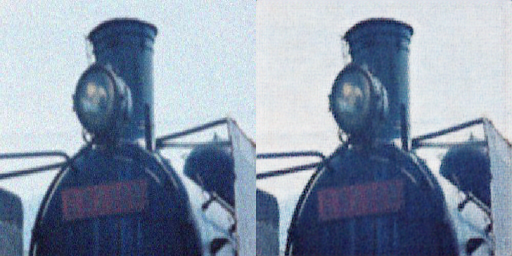

In [48]:
test_image_index = 3
test_image_index_2 = 2
dataloader_list = list(iter(dataloader))
output_image = image_manipulation.np_to_pil(
    generator(dataloader_list[test_image_index]['A'][test_image_index].unsqueeze(0).to(device)).detach().cpu().numpy()[0]
)

original_image = image_manipulation.np_to_pil(
    dataloader_list[test_image_index]['A'][test_image_index].detach().cpu().numpy()
)

new_image = Image.new(output_image.mode, (512, 256))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (256, 0))

new_image

In [47]:
import requests
from io import BytesIO

response = requests.get("https://pbs.twimg.com/media/FJ8XOTbagAcpzcm?format=png&name=small")
original_image = Image.open(BytesIO(response.content))
output_image = image_manipulation.np_to_pil(
    generator(transform(original_image).unsqueeze(0).to(device)).detach().cpu().numpy()[0]
)

new_image = Image.new(output_image.mode, (512, 256))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (256, 0))

In [49]:
torch.save(generator.state_dict(), "saved_models/generator.pth")
torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

In [95]:
os.path.exists("saved_models/generator.pth")

True